In [ ]:
# Instalar Graphviz y PyGraphviz correctamente en Colab
#!apt-get install -y graphviz libgraphviz-dev
#!pip install pygraphviz

# Descarga e importe de librerías, módulos y funciones

Librería no nativa de python, debe ser descargada para ser usada

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.5 MB/s eta 0:00:00


Importando las librerías que se van a utilizar en el proyecto

In [ ]:
# -----------------------------
# Librerías estándar de Python
# -----------------------------
import io
import os
import pickle
import random
import re
import sys
import tempfile
import zipfile
from pathlib import Path
from urllib.parse import urlparse
import csv

# -----------------------------
# Tipado
# -----------------------------
from typing import Any, Callable, Dict, List, Optional, Tuple

# -----------------------------
# Librerías de terceros
# -----------------------------
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import scipy.io
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# -----------------------------
# PyTorch y PyTorch Geometric
# -----------------------------
import torch
from torch_geometric.data import Data

# -----------------------------
# Google Colab
# -----------------------------
from google.colab import drive

# -----------------------------
# Visualización de las redes neuronales
# -----------------------------
from networkx.drawing.nx_agraph import graphviz_layout


Conectando a la carpeta en drive donde se encuentra el modulo y los archivos

In [ ]:
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/VIU/TFM')

Mounted at /content/drive


Importando clases y funciones desde el módulo NEATNNG

In [ ]:
from NEATNNG import Population
from NEATNNG import InnovationManager
from NEATNNG import FeedforwardGenome
from NEATNNG import crossover
from NEATNNG import mutate
from NEATNNG import StagnationManager
from NEATNNG import Species
from NEATNNG import Gene
from NEATNNG import ConnectionGene

# Función que obtiene las características de los grafos desde de la página Network Repository

In [ ]:
def extraer_estadisticas_red(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/112.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error al acceder a la URL: {e}")
        return {}

    soup = BeautifulSoup(response.text, "html.parser")
    text = soup.get_text(separator="\n")

    # Extraer la sección "Network Data Statistics"
    inicio = text.find("Network Data Statistics")
    if inicio == -1:
        print("No se encontró la sección de estadísticas.")
        return {}

    # Tomamos una porción grande de texto a partir de ahí (por ejemplo 1000 caracteres)
    stats_text = text[inicio:inicio+1000]

    # Diccionario con las métricas a buscar
    patrones = {
        "Nodes": r"Nodes\s+([0-9\.KM]+)",
        "Edges": r"Edges\s+([0-9\.KM]+)",
        "Density": r"Density\s+([0-9\.]+)",
        "Maximum degree": r"Maximum degree\s+([0-9\.K]+)",
        "Minimum degree": r"Minimum degree\s+([0-9]+)",
        "Average degree": r"Average degree\s+([0-9\.]+)",
        "Assortativity": r"Assortativity\s+([\-0-9\.]+)",
        "Number of triangles": r"Number of triangles\s+([0-9\.KM]+)",
        "Average number of triangles": r"Average number of triangles\s+([0-9\.]+)",
        "Maximum number of triangles": r"Maximum number of triangles\s+([0-9\.KM]+)",
        "Average clustering coefficient": r"Average clustering coefficient\s+([0-9\.]+)",
        "Fraction of closed triangles": r"Fraction of closed triangles\s+([0-9\.]+)",
        "Maximum k-core": r"Maximum k-core\s+([0-9]+)",
        "Lower bound of Maximum Clique": r"Lower bound of Maximum Clique\s+([0-9]+)",
    }

    #Diccionario con las características del grafo
    resultado = {}
    for campo, patron in patrones.items():
        match = re.search(patron, stats_text)
        if match:
            resultado[campo] = match.group(1)

    return resultado

# Construye la URL de descarga de los datos del grafo desde la página de Network Repository

In [ ]:
def build_zip_url(from_page_url: str, download_php_url: str) -> Tuple[str, str]:
    """
    Construye la URL de descarga .zip desde una estructura de URL de NRVIS.

    Args:
        from_page_url (str): URL a la página principal del dataset (usualmente termina en .php).
        download_php_url (str): URL de descarga al archivo PHP que maneja la petición de descarga.

    Returns:
        Tuple[str, str]: Una tupla con la URL del archivo ZIP y el nombre base del archivo.
    """
    parsed_download = urlparse(download_php_url)
    php_filename = os.path.basename(parsed_download.path)
    base_name = os.path.splitext(php_filename)[0]

    parsed_page = urlparse(from_page_url)
    page_path = parsed_page.path.strip('/')

    # Sacamos el directorio si termina en .php
    directory = page_path[:-4] if page_path.endswith('.php') else page_path

    zip_url = f"https://nrvis.com/download/data/{directory}/{base_name}.zip"
    return zip_url, base_name

# Función que lee archivos .edges

In [ ]:
def leer_archivo_edges(edges_path: str) -> list | None:
    """
    Lee un archivo .edges y devuelve una lista de aristas con dos nodos.
    Filtra líneas con más de dos columnas o valores no numéricos.
    """
    edge_lines = []
    try:
        with open(edges_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    try:
                        # Intentar convertir a enteros los primeros dos valores
                        node1, node2 = int(parts[0]), int(parts[1])
                        edge_lines.append((node1, node2))
                    except ValueError:
                        continue  # Ignorar líneas con valores no numéricos

        if edge_lines:
            return edge_lines
        else:
            print(f"Advertencia: No se encontraron aristas válidas en {edges_path}.")
            return None

    except Exception as e:
        print(f"Error al leer el archivo .edges en {edges_path}: {e}")
        return None

# Descarga los archivos que contienen la información del grafo desde la página Network Repository

In [ ]:
def cargar_grafo_desde_url(url: str) -> nx.Graph | None:
    """
    Descarga un archivo ZIP desde una URL, lo extrae e intenta cargar el grafo
    desde archivos .mtx o .edges encontrados, buscando en subdirectorios.
    """
    temp_dir = None
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        with tempfile.TemporaryDirectory() as tmpdir:
            temp_dir = tmpdir
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))
            zip_file.extractall(temp_dir)

            mtx_paths = []
            edges_paths = []
            for root, dirs, files in os.walk(temp_dir):
                relative_root = os.path.relpath(root, temp_dir)
                print(f"Directorio: {relative_root if relative_root != '.' else '(raíz)'}")
                for file in files:
                    print(f"- {file}")
                    if file.endswith(".mtx"):
                        mtx_paths.append(os.path.join(root, file))
                    elif file.endswith(".edges"):
                        edges_paths.append(os.path.join(root, file))

            if mtx_paths:
                mtx_path_to_load = mtx_paths[0]
                print(f"Archivo .mtx encontrado en: {mtx_path_to_load}. Cargando...")

                # Verificación de que el archivo no está vacío
                if os.stat(mtx_path_to_load).st_size == 0:
                    print("El archivo .mtx está vacío.")
                    return None

                adj_matrix = scipy.io.mmread(mtx_path_to_load)
                G = nx.from_scipy_sparse_array(adj_matrix)
                print(f"Grafo cargado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")
                return G
            elif edges_paths:
                edges_path_to_load = edges_paths[0]
                print(f"Archivo .edges encontrado en: {edges_path_to_load}. Cargando...")

                # Llamar a la subrutina para leer el archivo .edges
                edge_lines = leer_archivo_edges(edges_path_to_load)
                if edge_lines is not None:
                    G = nx.Graph()
                    G.add_edges_from(edge_lines)
                    print(f"Grafo cargado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")
                    return G
                else:
                    return None
            else:
                print("Error: No se encontró ningún archivo .mtx o .edges dentro del archivo ZIP.")
                return None

    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el archivo desde '{url}': {e}")
        return None
    except zipfile.BadZipFile:
        print(f"El archivo descargado desde '{url}' no es un archivo ZIP válido.")
        return None
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo de grafo después de la extracción.")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}")
        return None
    finally:
        pass

# Función que calcula la distancia promedio entre los nodos de un grafo, calculando distancias desde cada nodo solo una vez.

In [ ]:
def calculate_mean_distance(G: nx.Graph, nodes: List[int]) -> float:
    """
    Calcula la distancia promedio entre los nodos dados en un grafo G.
    Usa una estrategia eficiente calculando distancias desde cada nodo solo una vez.
    Muestra una barra de progreso usando tqdm.
    """
    total_length = 0
    count = 0

    for i, u in enumerate(tqdm(nodes, desc="Calculando distancias")):
        try:
            lengths = nx.single_source_shortest_path_length(G, u)
        except nx.NetworkXError:
            continue  # Saltar nodos sin caminos disponibles

        for v in nodes[i+1:]:
            if v in lengths:
                total_length += lengths[v]
                count += 1

    return total_length / count if count > 0 else float('inf')


# Función que identifica si el grafo es conexo o no para calcular su distancia promedio.

In [ ]:
def mean_node_distance(graph: nx.Graph, max_nodes: int = 10000, sample_size: int = 1000) -> float:
    """
    Calcula la distancia promedio entre nodos de un grafo.
    Usa muestreo si el grafo es muy grande.
    """
    if graph.number_of_nodes() == 0:
        return 0.0

    if not nx.is_connected(graph):
        # Trabajamos solo con el componente conexo más grande
        largest_cc = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_cc).copy()

    num_nodes = graph.number_of_nodes()

    if num_nodes <= max_nodes:
        try:
            return nx.average_shortest_path_length(graph)
        except (nx.NetworkXError, ZeroDivisionError):
            return float('inf')
    else:
        sampled_nodes = random.sample(list(graph.nodes()), min(sample_size, num_nodes))
        return calculate_mean_distance(graph, sampled_nodes)

# Función que organiza los datos de los grafos

In [ ]:
def extraer_datos_de_url(url_php: str, head_url: str) -> dict | None:
    """
    Extrae información de un grafo desde una URL de Network Repository.
    Construye la URL del archivo ZIP basándose en la URL de la página PHP y head_url.
    Maneja el caso de grafos desconectados para la distancia promedio.
    """

    url_zip, nombre_base = build_zip_url(head_url, url_php)
    print(f"Construyendo URL del archivo ZIP: {url_zip}")

    try:
        G = cargar_grafo_desde_url(url_zip)
        if G:
            estadistica_values = list(extraer_estadisticas_red(url_php).values())

            avg_shortest_path_length = mean_node_distance(G)
            print(f"Distancia promedio entre nodos: {avg_shortest_path_length}")

            datos_grafo = {
                'name': nombre_base,
                'nodes': estadistica_values[0],
                'edges': estadistica_values[1],
                'density': estadistica_values[2],
                'maximum_degree': estadistica_values[3],
                'minimum_degree': estadistica_values[4],
                'average_degree': estadistica_values[5],
                'assortativity': estadistica_values[6],
                'number_of_triangles': estadistica_values[7],
                'average_number_of_triangles': estadistica_values[8],
                'maximum_number_of_triangles': estadistica_values[9],
                'average_clustering_coefficient': estadistica_values[10],
                'fraction_of_closed_triangles': estadistica_values[11],
                'maximum_k-core': estadistica_values[12],
                'lower_bound_of_maximum_clique': estadistica_values[13],
                'avg_node_dis': avg_shortest_path_length
            }
            return datos_grafo
        else:
            print(f"No se pudo cargar el grafo desde: {url_zip}")
            return None
    except Exception as e:
        print(f"Ocurrió un error al procesar {url_php} (descarga desde {url_zip}): {e}")
        return None

# Función que carga la información de un grafo desde Network Repository en un DataFrame

In [ ]:
def url_dataframe(urls_php: str, head_url: str) -> pd.DataFrame:
    """
    Extrae información de un grafo desde una URL de Network Repository.
    Construye la URL del archivo ZIP basándose en la URL de la página PHP y head_url.
    Maneja el caso de grafos desconectados para la distancia promedio.
    """
    # Lista para almacenar los datos de cada URL
    lista_de_datos = []

    # Ciclo para procesar cada URL y agregar los datos a la lista
    for url_php in urls_php:

        datos = extraer_datos_de_url(url_php,head_url)
        if datos:
            lista_de_datos.append(datos)

    # Crear el DataFrame final a partir de la lista de diccionarios
    df_final_temp = pd.DataFrame(lista_de_datos)

    return df_final_temp

# Se crea el DataFrame en el cual se van a guardar los datos descargados desde la página

In [ ]:
columnas = [
        'name', 'nodes', 'edges', 'density', 'maximum_degree', 'minimum_degree',
        'average_degree', 'assortativity', 'number_of_triangles',
        'average_number_of_triangles', 'maximum_number_of_triangles',
        'average_clustering_coefficient', 'fraction_of_closed_triangles',
        'maximum_k-core', 'lower_bound_of_maximum_clique', 'avg_node_dis'
    ]
# Crear un DataFrame vacío (este es el bloque independiente)
df_final = pd.DataFrame(columns=columnas)


# Descargando los datos de Ant Colony, almacenando los valores en el DataFrame

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/asn.php'

urls_php = [
    "https://networkrepository.com/insecta-ant-colony1-day01.php",
    "https://networkrepository.com/insecta-ant-colony1-day02.php",
    "https://networkrepository.com/insecta-ant-colony1-day03.php",
    "https://networkrepository.com/insecta-ant-colony1-day04.php",
    "https://networkrepository.com/insecta-ant-colony1-day05.php",
    "https://networkrepository.com/insecta-ant-colony1-day06.php",
    "https://networkrepository.com/insecta-ant-colony1-day07.php",
    "https://networkrepository.com/insecta-ant-colony1-day08.php",
    "https://networkrepository.com/insecta-ant-colony1-day09.php",
    "https://networkrepository.com/insecta-ant-colony1-day10.php",
    "https://networkrepository.com/insecta-ant-colony1-day11.php",
    "https://networkrepository.com/insecta-ant-colony1-day12.php",
    "https://networkrepository.com/insecta-ant-colony2-day01.php",
    "https://networkrepository.com/insecta-ant-colony2-day02.php",
    "https://networkrepository.com/insecta-ant-colony2-day03.php",
    "https://networkrepository.com/insecta-ant-colony2-day04.php",
    "https://networkrepository.com/insecta-ant-colony2-day05.php",
    "https://networkrepository.com/insecta-ant-colony2-day06.php",
    "https://networkrepository.com/insecta-ant-colony2-day07.php",
    "https://networkrepository.com/insecta-ant-colony2-day08.php",
    "https://networkrepository.com/insecta-ant-colony3-day01.php",
    "https://networkrepository.com/insecta-ant-colony3-day02.php",
    "https://networkrepository.com/insecta-ant-colony3-day03.php",
    "https://networkrepository.com/insecta-ant-colony3-day04.php",
    "https://networkrepository.com/insecta-ant-colony3-day05.php",
    "https://networkrepository.com/insecta-ant-colony3-day06.php",
    "https://networkrepository.com/insecta-ant-colony3-day07.php",
    "https://networkrepository.com/insecta-ant-colony3-day09.php",
    "https://networkrepository.com/insecta-ant-colony3-day10.php",
    "https://networkrepository.com/insecta-ant-colony3-day11.php",
    "https://networkrepository.com/insecta-ant-colony5-day01.php",
    "https://networkrepository.com/insecta-ant-colony5-day02.php",
    "https://networkrepository.com/insecta-ant-colony5-day11.php",
    "https://networkrepository.com/insecta-ant-colony6-day01.php",
    "https://networkrepository.com/insecta-ant-colony6-day02.php",
    "https://networkrepository.com/insecta-ant-colony6-day03.php",
    "https://networkrepository.com/insecta-ant-colony6-day04.php",
    "https://networkrepository.com/insecta-ant-colony6-day05.php",
    "https://networkrepository.com/insecta-ant-colony6-day06.php",
    "https://networkrepository.com/insecta-ant-colony6-day07.php",
    "https://networkrepository.com/insecta-ant-colony6-day08.php",
    "https://networkrepository.com/insecta-ant-colony6-day09.php",
    "https://networkrepository.com/insecta-ant-colony6-day10.php",
    "https://networkrepository.com/insecta-ant-colony6-day12.php"
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)


# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Construyendo URL del archivo ZIP: https://nrvis.com/download/data/asn/insecta-ant-colony1-day01.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony1-day01.edges
Archivo .edges encontrado en: /tmp/tmpmdy0rf3g/insecta-ant-colony1-day01.edges. Cargando...
Grafo cargado con 113 nodos y 4550 aristas.
Distancia promedio entre nodos: 1.2809734513274336
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/asn/insecta-ant-colony1-day02.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony1-day02.edges
Archivo .edges encontrado en: /tmp/tmp_dj13937/insecta-ant-colony1-day02.edges. Cargando...
Grafo cargado con 113 nodos y 4573 aristas.
Distancia promedio entre nodos: 1.277338811630847
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/asn/insecta-ant-colony1-day03.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony1-day03.edges
Archivo .edges encontrado en: /tmp/tmpubez7ulc/insecta-ant-colony1-day03.edges. Cargando...
Grafo cargado con 113 nodos y 4483

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/ia.php'

urls_php = [
    "https://networkrepository.com/ia-email-EU.php",
    "https://networkrepository.com/ia-email-univ.php",
    'https://networkrepository.com/ia-escorts-dynamic.php',
    'https://networkrepository.com/ia-dnc-corecipient.php',
    'https://networkrepository.com/ia-fb-messages.php',
    'https://networkrepository.com/ia-infect-hyper.php',
    'https://networkrepository.com/ia-infect-dublin.php',
    'https://networkrepository.com/ia-enron-large.php',
    'https://networkrepository.com/ia-frwikinews-user-edits.php',
    'https://networkrepository.com/ia-primary-school-proximity.php',
    'https://networkrepository.com/ia-workplace-contacts.php',
    'https://networkrepository.com/ia-radoslaw-email.php',
    'https://networkrepository.com/ia-workplace-contacts.php',
    'https://networkrepository.com/ia-reality.php'
]


# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)


# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-email-EU.zip
Directorio: (raíz)
- readme.html
- ia-email-EU.mtx
Archivo .mtx encontrado en: /tmp/tmp_xilxi7g/ia-email-EU.mtx. Cargando...
Grafo cargado con 32430 nodos y 54397 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:45<00:00, 21.79it/s]


Distancia promedio entre nodos: 4.058882882882883
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-email-univ.zip
Directorio: (raíz)
- readme.html
- ia-email-univ.mtx
Archivo .mtx encontrado en: /tmp/tmp0w9fi19s/ia-email-univ.mtx. Cargando...
Grafo cargado con 1133 nodos y 5451 aristas.
Distancia promedio entre nodos: 3.606032017315423
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-escorts-dynamic.zip
Directorio: (raíz)
- readme.html
- ia-escorts-dynamic.edges
Archivo .edges encontrado en: /tmp/tmpscij56jc/ia-escorts-dynamic.edges. Cargando...
Grafo cargado con 10106 nodos y 39024 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:24<00:00, 40.96it/s]


Distancia promedio entre nodos: 4.190590590590591
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-dnc-corecipient.zip
Directorio: (raíz)
- readme.html
- ia-dnc-corecipient.edges
Archivo .edges encontrado en: /tmp/tmpc87d_wiq/ia-dnc-corecipient.edges. Cargando...
Grafo cargado con 906 nodos y 10429 aristas.
Distancia promedio entre nodos: 2.7595145231904348
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-fb-messages.zip
Directorio: (raíz)
- readme.html
- ia-fb-messages.mtx
Archivo .mtx encontrado en: /tmp/tmpq11nm76y/ia-fb-messages.mtx. Cargando...
Grafo cargado con 1266 nodos y 6451 aristas.
Distancia promedio entre nodos: 3.3103085251859206
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-infect-hyper.zip
Directorio: (raíz)
- ia-infect-hyper.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmp8ka9yjaz/ia-infect-hyper.mtx. Cargando...
Grafo cargado con 113 nodos y 2196 aristas.
Distancia promedio entre nodos: 1.65

Calculando distancias: 100%|██████████| 1000/1000 [01:15<00:00, 13.18it/s]


Distancia promedio entre nodos: 4.027709709709709
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-frwikinews-user-edits.zip
Directorio: (raíz)
- ia-frwikinews-user-edits.edges
- readme.html
Archivo .edges encontrado en: /tmp/tmpfcs3uszt/ia-frwikinews-user-edits.edges. Cargando...
Grafo cargado con 25042 nodos y 68679 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:38<00:00, 26.31it/s]


Distancia promedio entre nodos: 2.9665145145145146
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-primary-school-proximity.zip
Directorio: (raíz)
- readme.html
- ia-primary-school-proximity.edges
Archivo .edges encontrado en: /tmp/tmpogx4fzn4/ia-primary-school-proximity.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmpogx4fzn4/ia-primary-school-proximity.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/ia/ia-primary-school-proximity.zip
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/ia/ia-workplace-contacts.zip
Directorio: (raíz)
- readme.html
- ia-workplace-contacts.edges
Archivo .edges encontrado en: /tmp/tmpnpv2c_2l/ia-workplace-contacts.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmpnpv2c_2l/ia-workplace-contacts.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/ia/ia-workplace-contacts.zip
Construyendo URL del archivo ZIP: https://nrv

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/dimacs10.php'

urls_php = [
    'https://networkrepository.com/wing-nodal.php',
    'https://networkrepository.com/delaunay-n15.php',
    'https://networkrepository.com/fe-sphere.php',
    'https://networkrepository.com/delaunay-n14.php',
    'https://networkrepository.com/fe-4elt2.php',
    'https://networkrepository.com/delaunay-n13.php',
    'https://networkrepository.com/delaunay-n12.php',
    'https://networkrepository.com/delaunay-n11.php',
    'https://networkrepository.com/bio-celegansneural.php',
    'https://networkrepository.com/delaunay-n10.php',
    'https://networkrepository.com/polblogs.php',

]


# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)


# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/wing-nodal.zip
Directorio: (raíz)
- readme.html
- wing_nodal.mtx
Archivo .mtx encontrado en: /tmp/tmp6o6biiw7/wing_nodal.mtx. Cargando...
Grafo cargado con 10937 nodos y 75488 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:35<00:00, 28.33it/s]


Distancia promedio entre nodos: 11.467317317317317
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/delaunay-n15.zip
Directorio: (raíz)
- delaunay_n15.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmp3xpal792/delaunay_n15.mtx. Cargando...
Grafo cargado con 32768 nodos y 98274 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


Distancia promedio entre nodos: 43.118342342342345
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/fe-sphere.zip
Directorio: (raíz)
- readme.html
- fe-sphere.mtx
Archivo .mtx encontrado en: /tmp/tmpbm1n74bj/fe-sphere.mtx. Cargando...
Grafo cargado con 16386 nodos y 49152 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:31<00:00, 32.12it/s]


Distancia promedio entre nodos: 56.22876476476476
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/delaunay-n14.zip
Directorio: (raíz)
- delaunay_n14.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmpba2ln7va/delaunay_n14.mtx. Cargando...
Grafo cargado con 16384 nodos y 49122 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


Distancia promedio entre nodos: 32.9501981981982
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/fe-4elt2.zip
Directorio: (raíz)
- fe-4elt2.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmpokl8jbnw/fe-4elt2.mtx. Cargando...
Grafo cargado con 11143 nodos y 32818 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:16<00:00, 61.46it/s]


Distancia promedio entre nodos: 53.910576576576574
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/delaunay-n13.zip
Directorio: (raíz)
- readme.html
- delaunay_n13.mtx
Archivo .mtx encontrado en: /tmp/tmpl0zik2k_/delaunay_n13.mtx. Cargando...
Grafo cargado con 8192 nodos y 24547 aristas.
Distancia promedio entre nodos: 24.851146855876497
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/delaunay-n12.zip
Directorio: (raíz)
- readme.html
- delaunay_n12.mtx
Archivo .mtx encontrado en: /tmp/tmpiahuukt2/delaunay_n12.mtx. Cargando...
Grafo cargado con 4096 nodos y 12264 aristas.
Distancia promedio entre nodos: 18.281963880303724
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dimacs10/delaunay-n11.zip
Directorio: (raíz)
- readme.html
- delaunay_n11.mtx
Archivo .mtx encontrado en: /tmp/tmp976oaj1b/delaunay_n11.mtx. Cargando...
Grafo cargado con 2048 nodos y 6127 aristas.
Distancia promedio entre nodos: 13.345154971452125
Co

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/dynamic.php'

urls_php = [
    "https://networkrepository.com/insecta-ant-colony5.php",
    "https://networkrepository.com/insecta-ant-colony3.php",
    'https://networkrepository.com/insecta-ant-colony5.php',
    'https://networkrepository.com/ia-frwikinews-user-edits.php',
    'https://networkrepository.com/tech-as-topology.php',
    'https://networkrepository.com/insecta-ant-colony2.php',
    'https://networkrepository.com/insecta-ant-colony1.php',
    'https://networkrepository.com/soc-wiki-elec.php',
    'https://networkrepository.com/ia-movielens-user2tags-10m.php',
    'https://networkrepository.com/ia-radoslaw-email.php',
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)


# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/insecta-ant-colony5.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony5.edges
Archivo .edges encontrado en: /tmp/tmp2_n6jrc5/insecta-ant-colony5.edges. Cargando...
Grafo cargado con 152 nodos y 11363 aristas.
Distancia promedio entre nodos: 1.0098466364586964
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/insecta-ant-colony3.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony3.edges
Archivo .edges encontrado en: /tmp/tmp42y4erm7/insecta-ant-colony3.edges. Cargando...
Grafo cargado con 160 nodos y 12656 aristas.
Distancia promedio entre nodos: 1.0050314465408805
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/insecta-ant-colony5.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony5.edges
Archivo .edges encontrado en: /tmp/tmpe0ucw8kl/insecta-ant-colony5.edges. Cargando...
Grafo cargado con 152 nodos y 1

Calculando distancias: 100%|██████████| 1000/1000 [00:35<00:00, 27.81it/s]


Distancia promedio entre nodos: 2.9425645645645644
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/tech-as-topology.zip
Directorio: (raíz)
- tech-as-topology.edges
- readme.html
Archivo .edges encontrado en: /tmp/tmpuri1rmts/tech-as-topology.edges. Cargando...
Grafo cargado con 34761 nodos y 107720 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


Distancia promedio entre nodos: 3.75785985985986
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/insecta-ant-colony2.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony2.edges
Archivo .edges encontrado en: /tmp/tmplszv7o4y/insecta-ant-colony2.edges. Cargando...
Grafo cargado con 131 nodos y 8437 aristas.
Distancia promedio entre nodos: 1.0091603053435114
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/insecta-ant-colony1.zip
Directorio: (raíz)
- readme.html
- insecta-ant-colony1.edges
Archivo .edges encontrado en: /tmp/tmph0xe9ays/insecta-ant-colony1.edges. Cargando...
Grafo cargado con 113 nodos y 6113 aristas.
Distancia promedio entre nodos: 1.03397597977244
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/soc-wiki-elec.zip
Directorio: (raíz)
- readme.html
- soc-wiki-elec.edges
Archivo .edges encontrado en: /tmp/tmpxtc52f2j/soc-wiki-elec.edges. Cargando...
Grafo cargado con 7118 nodos y 100811 aristas.

Calculando distancias: 100%|██████████| 1000/1000 [00:27<00:00, 36.06it/s]


Distancia promedio entre nodos: 3.853827827827828
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/dynamic/ia-radoslaw-email.zip
Directorio: (raíz)
- readme.html
- ia-radoslaw-email.edges
Archivo .edges encontrado en: /tmp/tmpvnj57b6k/ia-radoslaw-email.edges. Cargando...
Grafo cargado con 167 nodos y 3251 aristas.
Distancia promedio entre nodos: 1.9673905201644903


In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/bio.php'

urls_php = [
    'https://networkrepository.com/bio-CE-GN.php',
    'https://networkrepository.com/bio-CE-GT.php',
    'https://networkrepository.com/bio-CE-HT.php',
    'https://networkrepository.com/bio-CE-LC.php',
    'https://networkrepository.com/bio-CE-PG.php',
    'https://networkrepository.com/bio-DR-CX.php',
    'https://networkrepository.com/bio-DM-CX.php',
    'https://networkrepository.com/bio-SC-HT.php',
    'https://networkrepository.com/bio-HS-LC.php',
    'https://networkrepository.com/bio-SC-CC.php',
    'https://networkrepository.com/bio-SC-GT.php',
    'https://networkrepository.com/bio-SC-LC.php',
    'https://networkrepository.com/bio-grid-human.php',
    'https://networkrepository.com/bio-grid-fruitfly.php',
    'https://networkrepository.com/bio-dmela.php',
    'https://networkrepository.com/bio-grid-fission-yeast.php',
    'https://networkrepository.com/bio-HS-HT.php',
    'https://networkrepository.com/bio-grid-worm.php',
    'https://networkrepository.com/bio-grid-plant.php',
    'https://networkrepository.com/bio-celegans-dir.php',
    'https://networkrepository.com/bio-yeast-protein-inter.php',
    'https://networkrepository.com/bio-SC-TS.php',
    'https://networkrepository.com/bio-diseasome.php'
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)


# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/bio/bio-CE-GN.zip
Directorio: (raíz)
- readme.html
- bio-CE-GN.edges
Archivo .edges encontrado en: /tmp/tmp8xf_6s40/bio-CE-GN.edges. Cargando...
Grafo cargado con 2220 nodos y 53683 aristas.
Distancia promedio entre nodos: 2.6984047748679143
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/bio/bio-CE-GT.zip
Directorio: (raíz)
- readme.html
- bio-CE-GT.edges
Archivo .edges encontrado en: /tmp/tmprtnjvdy2/bio-CE-GT.edges. Cargando...
Grafo cargado con 924 nodos y 3239 aristas.
Distancia promedio entre nodos: 3.7349033643893685
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/bio/bio-CE-HT.zip
Directorio: (raíz)
- readme.html
- bio-CE-HT.edges
Archivo .edges encontrado en: /tmp/tmpaytgx8vo/bio-CE-HT.edges. Cargando...
Grafo cargado con 2617 nodos y 2985 aristas.
Distancia promedio entre nodos: 8.647274974945141
Construyendo URL del archivo ZIP: http

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/inf.php'

urls_php = [
    'https://networkrepository.com/inf-euroroad.php',
    'https://networkrepository.com/inf-USAir97.php',
    'https://networkrepository.com/inf-power.php',
    'https://networkrepository.com/inf-openflights.php'
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)


# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/inf/inf-euroroad.zip
Directorio: (raíz)
- inf-euroroad.edges
- readme.html
Archivo .edges encontrado en: /tmp/tmpkbksacui/inf-euroroad.edges. Cargando...
Grafo cargado con 1174 nodos y 1417 aristas.
Distancia promedio entre nodos: 18.39514614059391
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/inf/inf-USAir97.zip
Directorio: (raíz)
- readme.html
- inf-USAir97.mtx
Archivo .mtx encontrado en: /tmp/tmpsl7w74vt/inf-USAir97.mtx. Cargando...
Grafo cargado con 332 nodos y 2126 aristas.
Distancia promedio entre nodos: 2.7381247042550867
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/inf/inf-power.zip
Directorio: (raíz)
- readme.html
- inf-power.mtx
Archivo .mtx encontrado en: /tmp/tmpq7q7dl45/inf-power.mtx. Cargando...
Grafo cargado con 4941 nodos y 6594 aristas.
Distancia promedio entre nodos: 18.989185424445708
Construyendo URL del archivo ZIP: ht

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/socfb.php'

urls_php = [
    'https://networkrepository.com/socfb-nips-ego.php',
    'https://networkrepository.com/socfb-Caltech36.php',
    'https://networkrepository.com/socfb-Reed98.php',
    'https://networkrepository.com/socfb-Simmons81.php',
    'https://networkrepository.com/socfb-Haverford76.php',
    'https://networkrepository.com/socfb-Swarthmore42.php',
    'https://networkrepository.com/socfb-USFCA72.php',
    'https://networkrepository.com/socfb-Mich67.php',
    'https://networkrepository.com/socfb-Bowdoin47.php',
    'https://networkrepository.com/socfb-Oberlin44.php',
    'https://networkrepository.com/socfb-Amherst41.php',
    'https://networkrepository.com/socfb-Hamilton46.php',
    'https://networkrepository.com/socfb-Wellesley22.php',
    'https://networkrepository.com/socfb-Smith60.php',
    'https://networkrepository.com/socfb-Trinity100.php',
    'https://networkrepository.com/socfb-Williams40.php',
    'https://networkrepository.com/socfb-Vassar85.php',
    'https://networkrepository.com/socfb-Middlebury45.php',
    'https://networkrepository.com/socfb-Brandeis99.php',
    'https://networkrepository.com/socfb-Wesleyan43.php',
    'https://networkrepository.com/socfb-Santa74.php',
    'https://networkrepository.com/socfb-Pepperdine86.php',
    'https://networkrepository.com/socfb-Colgate88.php',
    'https://networkrepository.com/socfb-UC64.php',
    'https://networkrepository.com/socfb-Bucknell39.php',
    'https://networkrepository.com/socfb-Rochester38.php',
    'https://networkrepository.com/socfb-Rice31.php',
    'https://networkrepository.com/socfb-JohnsHopkins55.php',
    'https://networkrepository.com/socfb-Vermont70.php',
    'https://networkrepository.com/socfb-Lehigh96.php',
    'https://networkrepository.com/socfb-Howard90.php',
    'https://networkrepository.com/socfb-UChicago30.php',
    'https://networkrepository.com/socfb-American75.php',
    'https://networkrepository.com/socfb-UCSC68.php',
    'https://networkrepository.com/socfb-Maine59.php',
    'https://networkrepository.com/socfb-Tufts18.php',
    'https://networkrepository.com/socfb-CMU.php',
    'https://networkrepository.com/socfb-Carnegie49.php',
    'https://networkrepository.com/socfb-MIT.php'
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

# Crear el DataFrame final a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)

# Concatenar df_final_temp al final de df_final
if df_final.empty:
  df_final = df_final_temp.copy()
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv('/content/drive/MyDrive/VIU/TFM/df_final.csv', index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/socfb/socfb-nips-ego.zip
Directorio: (raíz)
- readme.html
- socfb-nips-ego.edges
Archivo .edges encontrado en: /tmp/tmpu38pam66/socfb-nips-ego.edges. Cargando...
Grafo cargado con 2888 nodos y 2981 aristas.
Distancia promedio entre nodos: 3.8674212512485524
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/socfb/socfb-Caltech36.zip
Directorio: (raíz)
- readme.html
- socfb-Caltech36.mtx
Archivo .mtx encontrado en: /tmp/tmpkyyrxuuq/socfb-Caltech36.mtx. Cargando...
Grafo cargado con 769 nodos y 16656 aristas.
Distancia promedio entre nodos: 2.3378480449470755
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/socfb/socfb-Reed98.zip
Directorio: (raíz)
- readme.html
- socfb-Reed98.mtx
Archivo .mtx encontrado en: /tmp/tmpla1y20sm/socfb-Reed98.mtx. Cargando...
Grafo cargado con 962 nodos y 18812 aristas.
Distancia promedio entre nodos: 2.461460580087011
Co

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/soc.php'

urls_php = [
    'https://networkrepository.com/soc-brightkite.php',
    'https://networkrepository.com/soc-epinions.php',
    'https://networkrepository.com/soc-wiki-elec.php',
    'https://networkrepository.com/soc-gemsec-RO.php',
    'https://networkrepository.com/fb-pages-media.php',
    'https://networkrepository.com/soc-gemsec-HU.php',
    'https://networkrepository.com/soc-douban.php',
    'https://networkrepository.com/soc-slashdot.php',
    'https://networkrepository.com/soc-gemsec-HR.php',
    'https://networkrepository.com/soc-twitter-follows.php'
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)

print(df_final_temp.head())

# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-brightkite.zip
Directorio: (raíz)
- soc-brightkite.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmp443gckoa/soc-brightkite.mtx. Cargando...
Grafo cargado con 56739 nodos y 212945 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s]


Distancia promedio entre nodos: 4.8957037037037034
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-epinions.zip
Directorio: (raíz)
- readme.html
- soc-epinions.mtx
Archivo .mtx encontrado en: /tmp/tmpmf87jnmg/soc-epinions.mtx. Cargando...
Grafo cargado con 26588 nodos y 100120 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:57<00:00, 17.30it/s]


Distancia promedio entre nodos: 4.966494494494494
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-wiki-elec.zip
Directorio: (raíz)
- soc-wiki-elec.edges
- readme.html
Archivo .edges encontrado en: /tmp/tmp1ek42ces/soc-wiki-elec.edges. Cargando...
Grafo cargado con 7118 nodos y 100811 aristas.
Distancia promedio entre nodos: 3.2475679214219024
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-gemsec-RO.zip
Directorio: (raíz)
- soc-gemsec-RO.edges
- soc-gemsec-RO.json
- readme.html
Archivo .edges encontrado en: /tmp/tmpc3_jbium/soc-gemsec-RO.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmpc3_jbium/soc-gemsec-RO.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/soc/soc-gemsec-RO.zip
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/fb-pages-media.zip
Directorio: (raíz)
- fb-pages-media.nodes
- readme.html
- fb-pages-media.edges
Archivo .edges encontrado en: /tmp/tmpjst

Calculando distancias: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]


Distancia promedio entre nodos: 5.174732732732733
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-slashdot.zip
Directorio: (raíz)
- soc-slashdot.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmpookffbym/soc-slashdot.mtx. Cargando...
Grafo cargado con 70068 nodos y 358647 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


Distancia promedio entre nodos: 4.191073073073073
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-gemsec-HR.zip
Directorio: (raíz)
- soc-gemsec-HR.json
- readme.html
- soc-gemsec-HR.edges
Archivo .edges encontrado en: /tmp/tmpi2_qb3r2/soc-gemsec-HR.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmpi2_qb3r2/soc-gemsec-HR.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/soc/soc-gemsec-HR.zip
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-twitter-follows.zip
Directorio: (raíz)
- soc-twitter-follows.mtx
- readme.html
Archivo .mtx encontrado en: /tmp/tmpsl9bzz0g/soc-twitter-follows.mtx. Cargando...
Grafo cargado con 404719 nodos y 713319 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [18:08<00:00,  1.09s/it]

Distancia promedio entre nodos: 4.6817637637637635
             name   nodes   edges      density maximum_degree minimum_degree  \
0  soc-brightkite   56.7K  212.9K  0.000132294           1.1K              1   
1    soc-epinions   26.6K  100.1K  0.000283267            443              1   
2   soc-wiki-elec    7.1K    107K   0.00422842           1.3K              1   
3      soc-douban  154.9K  327.2K      2.72677            287              1   
4    soc-slashdot   70.1K  358.6K  0.000146105           2.5K              1   

  average_degree assortativity number_of_triangles  \
0              7    0.00962268                1.5M   
1              7     0.0572222              479.1K   
2             30    -0.0516799                2.5M   
3              4     -0.180331              121.8K   
4             10    -0.0651334                1.2M   

  average_number_of_triangles maximum_number_of_triangles  \
0                          26                       11.5K   
1                    

In [ ]:
print(df_final.tail())

                    name   nodes   edges      density maximum_degree  \
138         soc-epinions   26.6K  100.1K  0.000283267            443   
139        soc-wiki-elec    7.1K    107K   0.00422842           1.3K   
140           soc-douban  154.9K  327.2K      2.72677            287   
141         soc-slashdot   70.1K  358.6K  0.000146105           2.5K   
142  soc-twitter-follows  404.7K  713.3K      8.70979            626   

    minimum_degree average_degree assortativity number_of_triangles  \
138              1              7     0.0572222              479.1K   
139              1             30    -0.0516799                2.5M   
140              1              4     -0.180331              121.8K   
141              1             10    -0.0651334                1.2M   
142              1              3     -0.876372               88.6K   

    average_number_of_triangles maximum_number_of_triangles  \
138                          18                        5.2K   
139           

In [ ]:
# Lista de URLs

head_url = 'https://networkrepository.com/soc.php'

urls_php = [
    'https://networkrepository.com/fb-pages-sport.php',
    'https://networkrepository.com/soc-anybeat.php',
    'https://networkrepository.com/fb-pages-government.php',
    'https://networkrepository.com/fb-pages-company.php',
    'https://networkrepository.com/soc-advogato.php',
    'https://networkrepository.com/fb-pages-politician.php',
    'https://networkrepository.com/fb-pages-tvshow.php',
    'https://networkrepository.com/soc-wiki-Vote.php',
    'https://networkrepository.com/fb-pages-food.php'
]

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

#Se crea un DataFrame temporal a partir de la lista de diccionarios
df_final_temp = url_dataframe(urls_php,head_url)

print(df_final_temp.head())

# Asignar df_final_temp a df_final, si está vacío
if df_final.empty:
  df_final = df_final_temp.copy()
# Concatenar df_final_temp al final de df_final, si existe
else:
  df_final = pd.concat([df_final, df_final_temp], ignore_index=True)

#Guardar el archivo en el drive
df_final.to_csv(file_path, index=False)

print(df_final.tail())

Archivo existente encontrado. Cargando...
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/fb-pages-sport.zip
Directorio: (raíz)
- fb-pages-sport.nodes
- readme.html
- fb-pages-sport.edges
Archivo .edges encontrado en: /tmp/tmptrvt28wi/fb-pages-sport.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmptrvt28wi/fb-pages-sport.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/soc/fb-pages-sport.zip
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/soc-anybeat.zip
Directorio: (raíz)
- soc-anybeat.edges
- readme.html
Archivo .edges encontrado en: /tmp/tmpvnugfqld/soc-anybeat.edges. Cargando...
Grafo cargado con 12645 nodos y 49132 aristas.


Calculando distancias: 100%|██████████| 1000/1000 [00:26<00:00, 37.75it/s]


Distancia promedio entre nodos: 3.1204124124124126
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/fb-pages-government.zip
Directorio: (raíz)
- readme.html
- fb-pages-government.nodes
- fb-pages-government.edges
Archivo .edges encontrado en: /tmp/tmp_n28lb4j/fb-pages-government.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmp_n28lb4j/fb-pages-government.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/soc/fb-pages-government.zip
Construyendo URL del archivo ZIP: https://nrvis.com/download/data/soc/fb-pages-company.zip
Directorio: (raíz)
- fb-pages-company.edges
- readme.html
- fb-pages-company.nodes
Archivo .edges encontrado en: /tmp/tmp2289eb89/fb-pages-company.edges. Cargando...
Advertencia: No se encontraron aristas válidas en /tmp/tmp2289eb89/fb-pages-company.edges.
No se pudo cargar el grafo desde: https://nrvis.com/download/data/soc/fb-pages-company.zip
Construyendo URL del archivo ZIP: https://nrvis.com/d

In [ ]:
print(df_final.columns)

Index(['name', 'nodes', 'edges', 'density', 'maximum_degree', 'minimum_degree',
       'average_degree', 'assortativity', 'number_of_triangles',
       'average_number_of_triangles', 'maximum_number_of_triangles',
       'average_clustering_coefficient', 'fraction_of_closed_triangles',
       'maximum_k-core', 'lower_bound_of_maximum_clique', 'avg_node_dis'],
      dtype='object')


In [ ]:
print(df_final['edges'].describe())

count      146
unique     123
top       4.1K
freq         5
Name: edges, dtype: object


In [ ]:
import pandas as pd
import os

from google.colab import drive

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

print(df_final.describe())

Mounted at /content/drive
Google Drive montado exitosamente.
Archivo existente encontrado. Cargando...
          density  minimum_degree  average_degree  assortativity  \
count  146.000000      146.000000      146.000000     146.000000   
mean     0.981983       27.890411       67.940411       0.003881   
std      3.270436      111.124542      116.730122       0.173324   
min      0.000103        0.000000        2.000000      -0.876372   
25%      0.007081        1.000000       10.250000      -0.051680   
50%      0.025603        1.000000       62.000000       0.024794   
75%      0.697956       13.000000       88.000000       0.072843   
max     18.968600      788.000000      992.000000       0.921112   

       average_number_of_triangles  average_clustering_coefficient  \
count                   146.000000                      146.000000   
mean                    167.247260                        0.546793   
std                     286.338934                        0.605005   
min 

# Procesamiento de datos

## Función que convierte las abreviaturas K, M y B en miles, millones, o miles de millones

In [ ]:
def convert_abbrev(value):
    if isinstance(value, str):
        value = value.strip()
        if value.endswith('K'):
            return float(value[:-1]) * 1_000
        elif value.endswith('M'):
            return float(value[:-1]) * 1_000_000
        elif value.endswith('B'):
            return float(value[:-1]) * 1_000_000_000
    try:
        return float(value)
    except:
        return value




In [ ]:
# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/VIU/TFM/df_final.csv'

#Se revisa que el dataframe ya exista en el drive
if os.path.exists(file_path):
    print("Archivo existente encontrado. Cargando...")
    df_final = pd.read_csv(file_path)

# Columnas a convertir
cols_to_convert = [
    'nodes', 'edges', 'maximum_degree', 'minimum_degree',
    'average_degree', 'number_of_triangles',
    'average_number_of_triangles', 'maximum_number_of_triangles',
    'maximum_k-core', 'lower_bound_of_maximum_clique'
]

df_final_clean = df_final.copy()

# Aplicar la conversión
for col in cols_to_convert:
    df_final_clean[col] = df_final_clean[col].apply(convert_abbrev)

# Guardar el DataFrame como .csv
df_final_clean.to_csv("df_final_clean.csv", index=False)

print(df_final_clean.head())

Archivo existente encontrado. Cargando...
                        name  nodes   edges   density  maximum_degree  \
0  insecta-ant-colony1-day01  113.0  4600.0  0.719027           109.0   
1  insecta-ant-colony1-day02  113.0  4600.0  0.722661           106.0   
2  insecta-ant-colony1-day03  113.0  4500.0  0.708439           104.0   
3  insecta-ant-colony1-day04  113.0  4100.0  0.646966           101.0   
4  insecta-ant-colony1-day05  113.0  4100.0  0.655657           101.0   

   minimum_degree  average_degree  assortativity  number_of_triangles  \
0            42.0            80.0      -0.030061             292400.0   
1            27.0            80.0       0.019803             301200.0   
2            27.0            79.0       0.071674             292200.0   
3            27.0            72.0       0.069785             229500.0   
4            27.0            73.0       0.049266             236200.0   

   average_number_of_triangles  maximum_number_of_triangles  \
0                

In [ ]:
print(df_final_clean.describe())

               nodes          edges     density  maximum_degree  \
count     146.000000     146.000000  146.000000      146.000000   
mean     8606.006849   73645.205479    0.981983     1201.109589   
std     36587.639405   97202.273340    3.270436     4015.200006   
min        99.000000    1200.000000    0.000103        6.000000   
25%       160.000000    6525.000000    0.007081      127.000000   
50%      1750.000000   28050.000000    0.025603      254.500000   
75%      4825.000000  111900.000000    0.697956      673.000000   
max    404700.000000  713300.000000   18.968600    32600.000000   

       minimum_degree  average_degree  assortativity  number_of_triangles  \
count      146.000000      146.000000     146.000000         1.460000e+02   
mean        27.890411       67.940411       0.003881         2.033931e+07   
std        111.124542      116.730122       0.173324         9.769735e+07   
min          0.000000        2.000000      -0.876372         8.700000e+01   
25%        

Cargando el dataframe final

In [ ]:
df_final_clean = pd.read_csv("/content/drive/MyDrive/VIU/TFM/df_final_clean.csv")

# Función que prepara los datos para se usados en el modelo

In [ ]:
# Function to prepare graph data for the model
def prepare_graph_data(df: pd.DataFrame, scaled_features: np.ndarray, target_column: str) -> list[tuple[torch.Tensor, torch.Tensor]]:
    graph_data = []
    for i, row in enumerate(df.itertuples(index=False)):
        features = torch.tensor(scaled_features[i], dtype=torch.float32)
        target = torch.tensor([getattr(row, target_column)], dtype=torch.float32)
        graph_data.append((features, target))
    return graph_data

Se normalizan los valores dentro del dataframe

In [ ]:
# Define feature and target columns
feature_columns = [
    'nodes', 'edges', 'density', 'maximum_degree', 'minimum_degree',
    'average_degree', 'assortativity', 'number_of_triangles',
    'average_number_of_triangles', 'maximum_number_of_triangles',
    'average_clustering_coefficient', 'fraction_of_closed_triangles',
    'maximum_k-core', 'lower_bound_of_maximum_clique'
]
target_column = 'avg_node_dis'

# Guardar la columna 'name'
names = df_final_clean['name'].copy()

# Seleccionar solo las columnas necesarias para el modelo
df_final_clean = df_final_clean[feature_columns + [target_column]].copy()

# Volver a agregar 'name'
df_final_clean.insert(0, 'name', names)

# Separate features and target for scaling
X = df_final_clean[feature_columns].copy()
y = df_final_clean[target_column].copy()

# Initialize and fit the StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare the graph data using the scaled features
graph_data = prepare_graph_data(df_final_clean.copy(), X_scaled, target_column)

# Agregar las características normalizadas al DataFrame original
df_final_clean[feature_columns] = X_scaled

# Imprimir las primeras filas del DataFrame con las características normalizadas
print("Primeras filas de df_final_clean con características normalizadas:")
print(df_final_clean.head())

# Imprimir los primeros elementos de graph_data para verificar
print("\nPrimeros elementos de graph_data:")
for i in range(min(5, len(graph_data))):
    print(graph_data[i])


# Guardar el scaler
scaler_path = '/content/drive/MyDrive/VIU/TFM/scaler.pkl'

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler guardado en Drive.")

Primeras filas de df_final_clean con características normalizadas:
                        name     nodes     edges   density  maximum_degree  \
0  insecta-ant-colony1-day01 -0.232927 -0.712770 -0.080681       -0.272930   
1  insecta-ant-colony1-day02 -0.232927 -0.712770 -0.079566       -0.273680   
2  insecta-ant-colony1-day03 -0.232927 -0.713803 -0.083929       -0.274180   
3  insecta-ant-colony1-day04 -0.232927 -0.717932 -0.102791       -0.274929   
4  insecta-ant-colony1-day05 -0.232927 -0.717932 -0.100124       -0.274929   

   minimum_degree  average_degree  assortativity  number_of_triangles  \
0        0.127408        0.103667      -0.196501            -0.205900   
1       -0.008040        0.103667       0.092180            -0.205810   
2       -0.008040        0.095071       0.392480            -0.205902   
3       -0.008040        0.034897       0.381547            -0.206546   
4       -0.008040        0.043494       0.262752            -0.206478   

   average_number_of_tria

Separando el DataFrame entre los inliers y los outliers

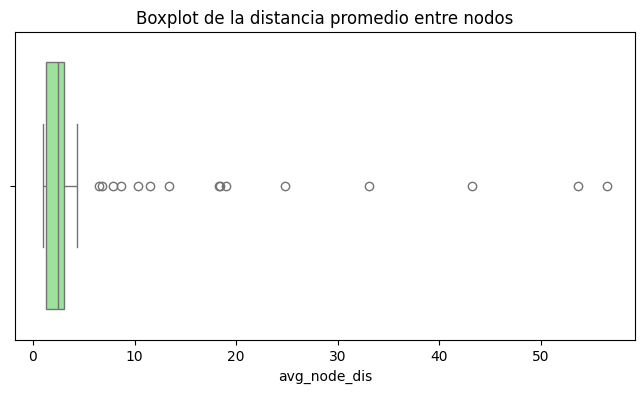

In [ ]:
df_final_clean = pd.read_csv("/content/drive/MyDrive/VIU/TFM/df_final_clean.csv")
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_final_clean['avg_node_dis'], color='lightgreen')
plt.title('Boxplot de la distancia promedio entre nodos')
plt.xlabel('avg_node_dis')
plt.show()

In [ ]:
# Umbral para detectar outliers usando el método IQR
Q1 = df_final_clean['avg_node_dis'].quantile(0.25)
Q3 = df_final_clean['avg_node_dis'].quantile(0.75)
IQR = Q3 - Q1
umbral_superior = Q3 + 1.5 * IQR

# Filtrar inliers
inliers = df_final_clean[df_final_clean['avg_node_dis'] <= umbral_superior]

# Filtrar outliers
outliers = df_final_clean[df_final_clean['avg_node_dis'] > umbral_superior]

In [ ]:
q1 = inliers['avg_node_dis'].quantile(0.25)
q3 = inliers['avg_node_dis'].quantile(0.75)
print(q1)
print(q3)

1.2941597495087498
2.7637130237838945


In [ ]:
print(inliers['avg_node_dis'].describe())


count    122.000000
mean       2.213855
std        0.924435
min        1.000000
25%        1.294160
50%        2.428150
75%        2.763713
max        4.339715
Name: avg_node_dis, dtype: float64


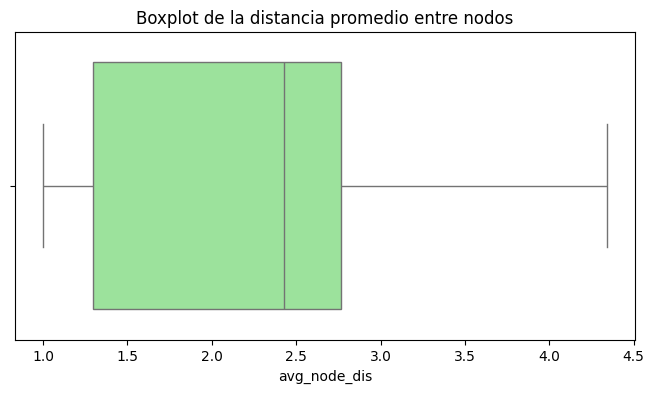

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=inliers['avg_node_dis'], color='lightgreen')
plt.title('Boxplot de la distancia promedio entre nodos')
plt.xlabel('avg_node_dis')
plt.show()

Se divide inliers en df_unseen y df_final

In [ ]:
df_soc = inliers[inliers['name'].str.startswith('soc')]
print(df_soc.shape)

(40, 16)


In [ ]:
# Calcular el número de filas que quieres en df_unseen
num_unseen = len(inliers) - 100  # El tamaño de df_unseen

# Seleccionar aleatoriamente las filas que no están en df_soc
remaining_inliers = inliers[~inliers['name'].str.startswith('soc')]  # Filtrar el resto

# Elegir aleatoriamente las filas para df_unseen
df_unseen = remaining_inliers.sample(n=num_unseen, random_state=42)
# Las filas que no fueron seleccionadas en df_unseen son parte de df_train
df_train = inliers[~inliers.index.isin(df_unseen.index)]

#Se elimina la columna 'name' por tratarse de una columna no numérica
df_unseen_nn = df_unseen.drop(columns=['name']).copy()
df_train_nn = df_train.drop(columns=['name']).copy()

# Verificar el tamaño de los DataFrames
print(f"Tamaño de df_unseen: {df_unseen_nn.shape}")
print(f"Tamaño de df_train: {df_train_nn.shape}")


Tamaño de df_unseen: (22, 15)
Tamaño de df_train: (100, 15)


In [ ]:
# Rutas a los archivos en Google Drive
file_path_train = '/content/drive/MyDrive/VIU/TFM/df_train_nn.csv'
file_path_unseen = '/content/drive/MyDrive/VIU/TFM/df_unseen_nn.csv'

#Se revisa si el dataframe existe en el drive
if os.path.exists(file_path_train):
    print("Archivo Train existente encontrado. Cargando...")
    df_train_nn = pd.read_csv(file_path_train)
#Se guarda en el drive
else:
    df_train_nn.to_csv(file_path_train, index=False)

#Se revisa si el dataframe existe en el drive
if os.path.exists(file_path_unseen):
    print("Archivo Train existente encontrado. Cargando...")
    df_unseen_nn = pd.read_csv(file_path_unseen)
#Se guarda en el drive
else:
    df_unseen_nn.to_csv(file_path_unseen, index=False)


Realizando el 5-fold sobre los inliers, aleatoriamente

In [ ]:
# Define feature and target columns
feature_columns = [
    'nodes', 'edges', 'density', 'maximum_degree', 'minimum_degree',
    'average_degree', 'assortativity', 'number_of_triangles',
    'average_number_of_triangles', 'maximum_number_of_triangles',
    'average_clustering_coefficient', 'fraction_of_closed_triangles',
    'maximum_k-core', 'lower_bound_of_maximum_clique'
]

target_column = 'avg_node_dis'

# Se obtienen los valores ya escalados
X_scaled = df_final_clean[feature_columns].values
y = df_final_clean[target_column].values

# Definir número de folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Crear folds
folds = []
for train_index, test_index in kf.split(df_train_nn):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_data = prepare_graph_data(df_train_nn.iloc[train_index], X_train, target_column)
    test_data = prepare_graph_data(df_train_nn.iloc[test_index], X_test, target_column)

    folds.append((train_data, test_data))

In [ ]:
import pickle

folds_path = "/content/drive/MyDrive/VIU/TFM/folds.pkl"

with open(folds_path, 'wb') as f:
    pickle.dump(folds, f)

print(f"Folds guardados en: {folds_path}")


Folds guardados en: /content/drive/MyDrive/VIU/TFM/folds.pkl


Se obtienen los valores de df_unseen como torch

In [ ]:
scaler_path = '/content/drive/MyDrive/VIU/TFM/scaler.pkl'
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

unseen_data = prepare_graph_data(df_unseen_nn, scaler.transform(df_unseen_nn[feature_columns]), target_column)

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'wb') as f:
    pickle.dump(unseen_data, f)

print(f"'unseen_data' guardado en: {unseen_data_path}")

NameError: name 'prepare_graph_data' is not defined

# Definir la función que genera el mejor genoma

In [ ]:
folds_path = "/content/drive/MyDrive/VIU/TFM/folds.pkl"

with open(folds_path, 'rb') as f:
    folds = pickle.load(f)

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)


In [ ]:
def best_genome_function(ps=100, folds=folds, unseen_data=unseen_data, trial=0, ct=3.0, st=20, ng=100,mr=3.0):


    path = "/content/drive/MyDrive/VIU/TFM/"
    # Carpeta para guardar los resultados
    os.makedirs(path +f"results_trial_{trial}", exist_ok=True)

    # Initialize Population
    population_size = ps
    num_inputs = unseen_data[0][0].shape[0]
    num_outputs = 1

    best_genome_overall = None
    lowest_test_loss = float('inf')

    best_genomes_per_fold = []
    test_losses_per_fold = []
    fitness_per_fold = []

    for i, (train_data, test_data) in enumerate(folds):

        print(f"\nFold {i+1}")

        # Reiniciar componentes evolutivos
        innovation_manager = InnovationManager()
        population = Population(population_size, innovation_manager)
        population.create_initial_population(num_inputs, num_outputs, initial_hidden_nodes=8)
        stagnation_manager = StagnationManager()

        # Evolutionary loop with early stopping
        num_generations = ng  # Set a maximum number of generations
        stagnation_tolerance = st
        best_overall_fitness = -float('inf')
        generations_without_improvement = 0

        for generation in range(num_generations):
            mutation_rate = mr * (1 - generation / num_generations)  # Decaimiento progresivo
            print(f"Generation {generation}")

            # FITNESS sobre train_data del fold
            population.evaluate_fitness(train_data)
            best_fitness = population.get_best_fitness()
            print(f"Best fitness: {best_fitness}")

            # Early stopping
            if best_fitness > best_overall_fitness:
                best_overall_fitness = best_fitness
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            # Comprobación de estancamiento
            if generations_without_improvement >= stagnation_tolerance:
                print(f"Early stopping: No improvement in {stagnation_tolerance} generations.")
                break  # Detiene el ciclo si hay estancamiento

            # Speciation
            species = {}
            compatibility_threshold = ct
            for genome in population.population:
                found_species = False
                for species_id, spec in species.items():
                    if spec.is_compatible(genome, compatibility_threshold):
                        spec.add_member(genome)
                        found_species = True
                        break
                if not found_species:
                    new_species = Species(genome)
                    species[id(new_species)] = new_species

            species_list = list(species.values())
            for spec in species_list:
                spec.adjust_fitnesses()

            # Update stagnation
            stagnation_status = stagnation_manager.update(species_list, generation)

            # Reproduction with stagnation penalty
            offspring = []
            total_adjusted_fitness = sum(spec.get_adjusted_fitness(spec.representative_genome) for spec in species_list)
            if total_adjusted_fitness == 0:
                total_adjusted_fitness = len(species_list)

            sorted_species = sorted(species_list, key=lambda s: s.get_adjusted_fitness(s.representative_genome), reverse=True)

            offspring_count = {}
            for spec in sorted_species:
                adjusted_fitness = spec.get_adjusted_fitness(spec.representative_genome)
                num_offspring = max(1, int(adjusted_fitness / total_adjusted_fitness * population_size))

                # Apply stagnation penalty
                if stagnation_status.get(spec, False):
                    num_offspring = max(1, num_offspring // 2)

                offspring_count[spec] = num_offspring

            new_population = []
            for spec in species_list:
                num_to_spawn = offspring_count.get(spec, 0)
                for _ in range(num_to_spawn):
                    if not spec.members:
                        continue
                    if len(spec.members) == 1 or random.random() < 0.25:
                        child = random.choice(spec.members).copy()
                    else:
                        parent1, parent2 = random.sample(spec.members, 2)
                        child = crossover(parent1, parent2, innovation_manager)
                    child = mutate(child, innovation_manager, mutation_rate)
                    new_population.append(child)

                spec.clear()

            while len(new_population) < population_size:
                new_population.append(random.choice(population.population).copy())

            population.population = new_population[:population_size]


        # Evaluar en el conjunto de prueba
        best_genome = population.get_best_genome()
        print(f"Best genome: {best_genome}")
        if best_genome:
            print(len(test_data))
            loss = best_genome.evaluate_genome(test_data)
            loss = loss if loss is not None else float('inf')
            print(f"Fold {i+1} - Test Loss: {loss:.4f}")

            if loss < lowest_test_loss:
                lowest_test_loss = loss
                best_genome_overall = best_genome

            gem_num = (trial-1)*5+i+1
            data = {
                'genome': best_genome,
                'test_loss': loss,
                'best_fitness': best_fitness
            }

            with open(path + f"results_trial_{trial}/genome_{gem_num}.pkl", "wb") as f:
                pickle.dump(data, f)
            best_genomes_per_fold.append(best_genome)
            test_losses_per_fold.append(loss)
            fitness_per_fold.append(best_fitness)

            csv_file = path + f"results_trial_{trial}/metrics.csv"
            write_header = not os.path.exists(csv_file)

            with open(csv_file, mode='a', newline='') as f:
                writer = csv.writer(f)
                if write_header:
                    writer.writerow(["fold", "genome_file", "test_loss", "fitness"])
                writer.writerow([i + 1, f"genome_{gem_num}.pkl", loss, best_fitness])

    return best_genomes_per_fold, test_losses_per_fold, fitness_per_fold

In [ ]:
trial = 1
ps = 100
mr = 0.15
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best fitness: -89.929904961586
Generation 1
Best fitness: -89.6676962941885
Generation 2
Best fitness: -89.6676962941885
Generation 3
Best fitness: -89.5613090455532
Generation 4
Best fitness: -89.5613090455532
Generation 5
Best fitness: -88.84540376067162
Generation 6
Best fitness: -87.32976892217994
Generation 7
Best fitness: -87.32976892217994
Generation 8
Best fitness: -87.22984982728958
Generation 9
Best fitness: -87.22984982728958
Generation 10
Best fitness: -87.22984982728958
Generation 11
Best fitness: -87.22984982728958
Generation 12
Best fitness: -87.22984982728958
Generation 13
Best fitness: -87.22984982728958
Generation 14
Best fitness: -87.22984982728958
Generation 15
Best fitness: -87.22984982728958
Generation 16
Best fitness: -87.0807169153355
Generation 17
Best fitness: -87.0807169153355
Generation 18
Best fitness: -87.0807169153355
Generation 19
Best fitness: -87.0807169153355
Generation 20
Best fitness: -87.0807169153355
Generation 21
Best fitness: -87.0807169153355
G

([<NEATNNG.FeedforwardGenome at 0x78c9375ded50>,
 [-111.92754192352295,
  -117.06787481307984,
  -88.10757331848144,
  -83.79030265808106,
  -101.12368535995483],
 [-82.16424910016357,
  -86.15724287629128,
  -93.53541419506072,
  -92.49306506514549,
  -87.54168345332145])

In [ ]:
trial = 2
ps = 100
mr = 0.225
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0
Best fitness: -91.54991689920425
Generation 1
Best fitness: -90.42187936306
Generation 2
Best fitness: -89.29705137014389
Generation 3
Best fitness: -89.29705137014389
Generation 4
Best fitness: -89.29705137014389
Generation 5
Best fitness: -89.29705137014389
Generation 6
Best fitness: -89.29705137014389
Generation 7
Best fitness: -89.29705137014389
Generation 8
Best fitness: -88.1009360089898
Generation 9
Best fitness: -88.1009360089898
Generation 10
Best fitness: -88.1009360089898
Generation 11
Best fitness: -88.1009360089898
Generation 12
Best fitness: -88.1009360089898
Generation 13
Best fitness: -88.1009360089898
Generation 14
Best fitness: -88.1009360089898
Generation 15
Best fitness: -88.1009360089898
Generation 16
Best fitness: -88.1009360089898
Generation 17
Best fitness: -88.1009360089898
Generation 18
Best fitness: -88.1009360089898
Generation 19
Best fitness: -88.1009360089898
Generation 20
Best fitness: -86.63389461208135
Generation 21
Best fitness: -8

([<NEATNNG.FeedforwardGenome at 0x78c9350ee9d0>,
 [-111.52443399429322,
  -105.72923693656921,
  -90.17458572387696,
  -94.6291524887085,
  -106.61005492210388],
 [-86.62814190387726,
  -85.06234993338585,
  -91.90679239034652,
  -92.60956728458405,
  -88.51133045554161])

In [ ]:
trial = 3
ps = 100
mr = 0.3
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0
Best fitness: -89.09545681476592
Generation 1
Best fitness: -89.09545681476592
Generation 2
Best fitness: -87.791245678626
Generation 3
Best fitness: -87.791245678626
Generation 4
Best fitness: -87.39982680827379
Generation 5
Best fitness: -87.39982680827379
Generation 6
Best fitness: -87.39982680827379
Generation 7
Best fitness: -87.39982680827379
Generation 8
Best fitness: -87.39982680827379
Generation 9
Best fitness: -87.39982680827379
Generation 10
Best fitness: -87.39982680827379
Generation 11
Best fitness: -87.39982680827379
Generation 12
Best fitness: -87.39982680827379
Generation 13
Best fitness: -87.39982680827379
Generation 14
Best fitness: -87.39982680827379
Generation 15
Best fitness: -87.39982680827379
Generation 16
Best fitness: -84.65977497994899
Generation 17
Best fitness: -84.65977497994899
Generation 18
Best fitness: -84.65977497994899
Generation 19
Best fitness: -84.65977497994899
Generation 20
Best fitness: -84.65977497994899
Generation 21
Best 

([<NEATNNG.FeedforwardGenome at 0x78c93766ff90>,
 [-110.6297451019287,
  -109.3681571006775,
  -81.36144495010376,
  -92.13787593841553,
  -82.80940175056458],
 [-84.65977497994899,
  -85.28460829257965,
  -91.85109339356423,
  -92.23587228246033,
  -88.75132505893707])

In [ ]:
trial = 4
ps = 150
mr = 0.15
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0
Best fitness: -89.55114243030548
Generation 1
Best fitness: -87.55718523263931
Generation 2
Best fitness: -87.46198505380889
Generation 3
Best fitness: -87.46198505380889
Generation 4
Best fitness: -87.46198505380889
Generation 5
Best fitness: -87.46198505380889
Generation 6
Best fitness: -87.46198505380889
Generation 7
Best fitness: -87.46198505380889
Generation 8
Best fitness: -87.46198505380889
Generation 9
Best fitness: -87.46198505380889
Generation 10
Best fitness: -87.46198505380889
Generation 11
Best fitness: -87.46198505380889
Generation 12
Best fitness: -87.46198505380889
Generation 13
Best fitness: -87.46198505380889
Generation 14
Best fitness: -87.46198505380889
Generation 15
Best fitness: -87.46198505380889
Generation 16
Best fitness: -87.46198505380889
Generation 17
Best fitness: -87.46198505380889
Generation 18
Best fitness: -87.46198505380889
Generation 19
Best fitness: -87.46198505380889
Generation 20
Best fitness: -87.46198505380889
Generation 21
B

([<NEATNNG.FeedforwardGenome at 0x78c93767e150>,
 [-100.2908742904663,
  -109.74734373092652,
  -89.87926578521729,
  -83.87964820861816,
  -93.80260882973671],
 [-87.46198505380889,
  -86.51399551712093,
  -92.37953858375549,
  -91.39422801733016,
  -88.515853703022])

In [ ]:
trial = 5
ps = 150
mr = 0.225
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best fitness: -88.31387759745121
Generation 1
Best fitness: -88.31387759745121
Generation 2
Best fitness: -87.5690907716751
Generation 3
Best fitness: -87.5690907716751
Generation 4
Best fitness: -87.5690907716751
Generation 5
Best fitness: -87.5690907716751
Generation 6
Best fitness: -87.5690907716751
Generation 7
Best fitness: -87.5690907716751
Generation 8
Best fitness: -87.5690907716751
Generation 9
Best fitness: -85.34706714749336
Generation 10
Best fitness: -85.34706714749336
Generation 11
Best fitness: -85.34706714749336
Generation 12
Best fitness: -85.34706714749336
Generation 13
Best fitness: -85.34706714749336
Generation 14
Best fitness: -85.34706714749336
Generation 15
Best fitness: -85.34706714749336
Generation 16
Best fitness: -85.34706714749336
Generation 17
Best fitness: -85.34706714749336
Generation 18
Best fitness: -85.34706714749336
Generation 19
Best fitness: -85.34706714749336
Generation 20
Best fitness: -85.34706714749336
Generation 21
Best fitness: -85.34706714749

([<NEATNNG.FeedforwardGenome at 0x78021b1f4f50>,
 [-107.01826038360596,
  -107.40190939903259,
  -91.61238684654236,
  -90.49213285446167,
  -103.87150144577026],
 [-84.38275022879243,
  -87.00055997371673,
  -93.20709754228592,
  -90.36647045612335,
  -87.26135827153921])

In [ ]:
trial = 6
ps = 150
mr = 0.3
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0
Best fitness: -88.5730294585228
Generation 1
Best fitness: -88.5730294585228
Generation 2
Best fitness: -88.5730294585228
Generation 3
Best fitness: -87.99606841206551
Generation 4
Best fitness: -87.99606841206551
Generation 5
Best fitness: -87.99606841206551
Generation 6
Best fitness: -87.99606841206551
Generation 7
Best fitness: -87.99606841206551
Generation 8
Best fitness: -87.99606841206551
Generation 9
Best fitness: -87.99606841206551
Generation 10
Best fitness: -87.99606841206551
Generation 11
Best fitness: -87.99606841206551
Generation 12
Best fitness: -87.99606841206551
Generation 13
Best fitness: -87.99606841206551
Generation 14
Best fitness: -87.3430558502674
Generation 15
Best fitness: -87.3430558502674
Generation 16
Best fitness: -87.3430558502674
Generation 17
Best fitness: -87.3430558502674
Generation 18
Best fitness: -87.3430558502674
Generation 19
Best fitness: -87.3430558502674
Generation 20
Best fitness: -87.3430558502674
Generation 21
Best fitnes

([<NEATNNG.FeedforwardGenome at 0x78021b369e10>,
 [-97.41077508926392,
  -109.6076738357544,
  -90.8279317855835,
  -85.49636266231536,
  -107.16755619049073],
 [-87.3430558502674,
  -86.42971805963461,
  -92.24502328038216,
  -89.35788272023201,
  -88.66779135465622])

In [ ]:
trial = 7
ps = 200
mr = 0.15
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best fitness: -89.44362332820893
Generation 1
Best fitness: -88.73346610069275
Generation 2
Best fitness: -88.73346610069275
Generation 3
Best fitness: -88.73346610069275
Generation 4
Best fitness: -88.73346610069275
Generation 5
Best fitness: -88.73346610069275
Generation 6
Best fitness: -88.7097978413105
Generation 7
Best fitness: -88.7097978413105
Generation 8
Best fitness: -87.70007695257664
Generation 9
Best fitness: -87.70007695257664
Generation 10
Best fitness: -87.70007695257664
Generation 11
Best fitness: -87.27902725934982
Generation 12
Best fitness: -87.27902725934982
Generation 13
Best fitness: -87.27902725934982
Generation 14
Best fitness: -87.27902725934982
Generation 15
Best fitness: -87.27902725934982
Generation 16
Best fitness: -87.27902725934982
Generation 17
Best fitness: -87.27902725934982
Generation 18
Best fitness: -87.27902725934982
Generation 19
Best fitness: -87.17221199958585
Generation 20
Best fitness: -87.17221199958585
Generation 21
Best fitness: -87.172211

([<NEATNNG.FeedforwardGenome at 0x7f8ef1cb8790>,
 [-104.46694469451904,
  -107.63093204498291,
  -83.09726505279541,
  -87.27099962234497,
  -102.36665592193603],
 [-87.00893285274506,
  -85.60901241749525,
  -91.15510788112879,
  -90.25370605289936,
  -88.30505064427852])

In [ ]:
trial = 8
ps = 200
mr = 0.225
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0
Best fitness: -89.82632673978806
Generation 1
Best fitness: -88.80680961608887
Generation 2
Best fitness: -88.80680961608887
Generation 3
Best fitness: -88.80680961608887
Generation 4
Best fitness: -88.80680961608887
Generation 5
Best fitness: -88.80680961608887
Generation 6
Best fitness: -88.03474481105805
Generation 7
Best fitness: -88.03474481105805
Generation 8
Best fitness: -88.03474481105805
Generation 9
Best fitness: -88.03474481105805
Generation 10
Best fitness: -88.03474481105805
Generation 11
Best fitness: -87.53995530605316
Generation 12
Best fitness: -87.53995530605316
Generation 13
Best fitness: -87.53995530605316
Generation 14
Best fitness: -87.53995530605316
Generation 15
Best fitness: -87.53995530605316
Generation 16
Best fitness: -87.53995530605316
Generation 17
Best fitness: -87.53995530605316
Generation 18
Best fitness: -87.53995530605316
Generation 19
Best fitness: -87.53995530605316
Generation 20
Best fitness: -87.53995530605316
Generation 21
B

([<NEATNNG.FeedforwardGenome at 0x7f8ef18f9f50>,
 [-103.42714414596557,
  -111.49898109436035,
  -91.20218658447266,
  -88.97792620658875,
  -99.46841478347778],
 [-87.1790458291769,
  -85.0255520284176,
  -90.13936690092086,
  -90.89962850809097,
  -87.6957096338272])

In [ ]:
trial = 9
ps = 200
mr = 0.3
best_genome_function(ps=ps, trial=trial,mr=mr)


Fold 1
Generation 0
Best fitness: -88.08013927638531
Generation 1
Best fitness: -86.88411019146443
Generation 2
Best fitness: -86.88411019146443
Generation 3
Best fitness: -86.88411019146443
Generation 4
Best fitness: -86.88411019146443
Generation 5
Best fitness: -86.88411019146443
Generation 6
Best fitness: -86.88411019146443
Generation 7
Best fitness: -86.88411019146443
Generation 8
Best fitness: -86.88411019146443
Generation 9
Best fitness: -86.88411019146443
Generation 10
Best fitness: -86.88411019146443
Generation 11
Best fitness: -86.88411019146443
Generation 12
Best fitness: -86.88411019146443
Generation 13
Best fitness: -86.88411019146443
Generation 14
Best fitness: -86.88411019146443
Generation 15
Best fitness: -86.88411019146443
Generation 16
Best fitness: -86.88411019146443
Generation 17
Best fitness: -86.88411019146443
Generation 18
Best fitness: -86.88411019146443
Generation 19
Best fitness: -86.88411019146443
Generation 20
Best fitness: -86.88411019146443
Generation 21
B

([<NEATNNG.FeedforwardGenome at 0x7f8ef1473f90>,
 [-110.27785587310791,
  -100.95725870132446,
  -83.14623074531555,
  -86.24743285179139,
  -93.44456157684326],
 [-86.88411019146443,
  -86.97488218545914,
  -90.4186084151268,
  -91.49824501276017,
  -88.51370378732682])

Gráfica para visualizar las predicciones de los genomas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
Explorando carpeta: results_trial_1
  Leyendo archivo: genome_1.pkl
    Genoma genome_1 cargado.
  Leyendo archivo: genome_2.pkl
    Genoma genome_2 cargado.
  Leyendo archivo: genome_3.pkl
    Genoma genome_3 cargado.
  Leyendo archivo: genome_4.pkl
    Genoma genome_4 cargado.
  Leyendo archivo: genome_5.pkl
    Genoma genome_5 cargado.
Explorando carpeta: results_trial_2
  Leyendo archivo: genome_6.pkl
    Genoma genome_6 cargado.
  Leyendo archivo: genome_7.pkl
    Genoma genome_7 cargado.
  Leyendo archivo: genome_8.pkl
    Genoma genome_8 cargado.
  Leyendo archivo: genome_9.pkl
    Genoma genome_9 cargado.
  Leyendo archivo: genome_10.pkl
    Genoma genome_10 cargado.
Explorando carpeta: results_trial_3
  Leyendo archivo: genome_11.pkl
    Genoma genome_11 cargado.
  Leyendo archivo: genome_12.pkl
    Genoma genome_12

<ipython-input-14-d10dcd7d4c1c>:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(all_genomas))


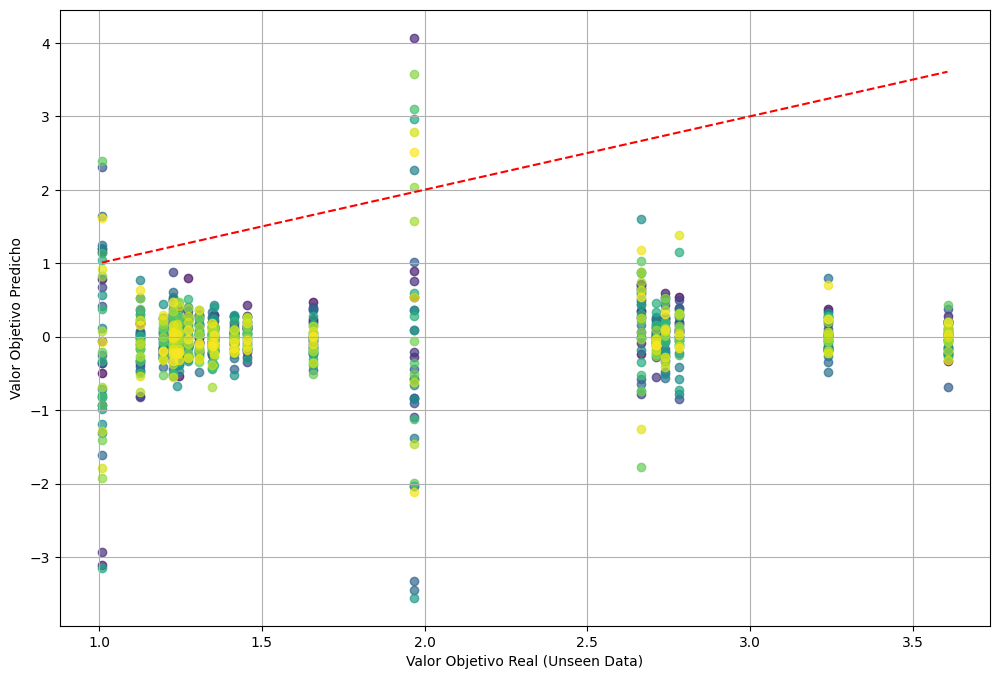

In [ ]:
import pickle
import matplotlib.pyplot as plt
import torch
import os
from google.colab import drive

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# 2. Define your get_prediction_for_single_data_point function (asegúrate de que esté definida en tu código)
def get_prediction_for_single_data_point(genome, data_point):
    """Evaluates a genome on a single data point and returns prediction and true value."""
    features, true_value = data_point
    network = genome.create_pytorch_network(num_inputs=features.shape[0])
    network.eval()
    with torch.no_grad():
        prediction = network(features.unsqueeze(0)).squeeze()
    return prediction.item(), true_value.item()

# 3. Función para visualizar las predicciones de los genomas cargados desde archivos individuales
def visualizar_predicciones_genomas_individuales(unseen_data, ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'):
    """
    Carga los genomas de archivos individuales dentro de las carpetas de cada trial
    y visualiza sus predicciones sobre los datos no vistos.

    Args:
        unseen_data (list): Lista de tuplas (features, true_value) para los datos no vistos.
        ruta_carpeta_principal (str, optional): Ruta a la carpeta principal que contiene las carpetas de los trials.
                                              Por defecto, '/content/drive/MyDrive/VIU/TFM'.
    """
    all_genomas = {}
    genome_labels = {}

    try:
        for item in os.listdir(ruta_carpeta_principal):
            ruta_carpeta_trial = os.path.join(ruta_carpeta_principal, item)
            if os.path.isdir(ruta_carpeta_trial) and item.startswith('results_trial_'):
                print(f"Explorando carpeta: {item}")
                for filename in os.listdir(ruta_carpeta_trial):
                    if filename.startswith('genome_') and filename.endswith('.pkl'):
                        genome_id = filename[:-4]  # Elimina la extensión .pkl para usar como ID
                        filepath = os.path.join(ruta_carpeta_trial, filename)
                        print(f"  Leyendo archivo: {filename}")
                        try:
                            with open(filepath, 'rb') as f:
                                data = pickle.load(f)
                                if 'genome' in data:
                                    genome = data['genome']
                                    all_genomas[genome_id] = genome
                                    # Intentar extraer información adicional para la etiqueta
                                    test_loss = data.get('test_loss', 'N/A')
                                    best_fitness = data.get('best_fitness', 'N/A')
                                    genome_labels[genome_id] = f"{genome_id} (Loss={test_loss:.2f}, Fitness={best_fitness:.2f})"
                                    print(f"    Genoma {genome_id} cargado.")
                                else:
                                    print(f"    Advertencia: No se encontró 'genome' en {filename}")
                        except Exception as e:
                            print(f"    Error al cargar {filename}: {e}")

    except FileNotFoundError:
        print(f"Error: La carpeta '{ruta_carpeta_principal}' no fue encontrada.")
        return
    except Exception as e:
        print(f"Ocurrió un error al procesar las carpetas: {e}")
        return

    if not all_genomas:
        print("No se encontraron genomas para visualizar.")
        return

    plt.figure(figsize=(12, 8))
    colors = plt.cm.get_cmap('viridis', len(all_genomas))

    for i, (genome_id, genome) in enumerate(all_genomas.items()):
        predictions = []
        true_values = []
        try:
            for features, true_value in unseen_data:
                prediction, _ = get_prediction_for_single_data_point(genome, (features, true_value))
                predictions.append(prediction)
                true_values.append(true_value.item())
        except Exception as e:
            print(f"Error al obtener predicciones para genoma {genome_id}: {e}")
            continue

        plt.scatter(true_values, predictions, color=colors(i), label=genome_labels.get(genome_id, genome_id), alpha=0.7)

    # Línea de predicción ideal
    all_true_values = [item.item() for _, item in unseen_data]
    if all_true_values:
        min_val = min(all_true_values)
        max_val = max(all_true_values)
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Predicción Ideal")

    plt.xlabel("Valor Objetivo Real (Unseen Data)")
    plt.ylabel("Valor Objetivo Predicho")
    #plt.title("Predicciones de Genomas Individuales sobre Unseen Data")
    #plt.legend()
    plt.grid(True)
    plt.show()

visualizar_predicciones_genomas_individuales(unseen_data)

In [ ]:
import pickle
import torch
import os
from sklearn.metrics import mean_squared_error
import numpy as np
from google.colab import drive

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# 2. Define your get_prediction_for_single_data_point function (asegúrate de que esté definida en tu código)
def get_prediction_for_single_data_point(genome, data_point):
    """Evaluates a genome on a single data point and returns prediction and true value."""
    features, true_value = data_point
    network = genome.create_pytorch_network(num_inputs=features.shape[0])
    network.eval()
    with torch.no_grad():
        prediction = network(features.unsqueeze(0)).squeeze()
    return prediction.item(), true_value.item()

# 4. Función para generar los datos de la tabla de MSE por genoma
def generar_tabla_mse_por_genoma(unseen_data, ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'):
    """
    Carga los genomas de archivos individuales dentro de las carpetas de cada trial
    y calcula el MSE de cada genoma sobre los datos no vistos.

    Args:
        unseen_data (list): Lista de tuplas (features, true_value) para los datos no vistos.
        ruta_carpeta_principal (str, optional): Ruta a la carpeta principal que contiene las carpetas de los trials.
                                                 Por defecto, '/content/drive/MyDrive/VIU/TFM'.

    Returns:
        dict: Un diccionario donde las claves son los nombres de los trials
              y los valores son listas de diccionarios, cada uno conteniendo
              el ID del genoma, el MSE y los hiperparámetros del trial (si están disponibles).
    """
    resultados_por_trial = {}

    try:
        for item in os.listdir(ruta_carpeta_principal):
            ruta_carpeta_trial = os.path.join(ruta_carpeta_principal, item)
            if os.path.isdir(ruta_carpeta_trial) and item.startswith('results_trial_'):
                print(f"Procesando carpeta: {item}")
                trial_id = item.split('_')[-1]  # Extraer el número del trial
                resultados_trial = []
                population_size = None
                mutation_rate = None

                # Intentar leer el archivo de configuración del trial si existe
                config_file = os.path.join(ruta_carpeta_trial, 'config.pkl')
                if os.path.exists(config_file):
                    try:
                        with open(config_file, 'rb') as f:
                            config = pickle.load(f)
                            population_size = config.get('population_size')
                            mutation_rate = config.get('mutation_rate')
                    except Exception as e:
                        print(f"  Advertencia: Error al leer el archivo de configuración: {e}")

                for filename in os.listdir(ruta_carpeta_trial):
                    if filename.startswith('genome_') and filename.endswith('.pkl'):
                        genome_id = filename[:-4]
                        filepath = os.path.join(ruta_carpeta_trial, filename)
                        print(f"  Leyendo archivo: {filename}")
                        try:
                            with open(filepath, 'rb') as f:
                                data = pickle.load(f)
                                if 'genome' in data:
                                    genome = data['genome']
                                    predictions = []
                                    true_values = []
                                    for features, true_value in unseen_data:
                                        prediction, _ = get_prediction_for_single_data_point(genome, (features, true_value))
                                        predictions.append(prediction)
                                        true_values.append(true_value.item())

                                    mse = mean_squared_error(true_values, predictions)
                                    resultados_trial.append({
                                        'genome_id': genome_id,
                                        'mse': mse,
                                        'population_size': population_size,
                                        'mutation_rate': mutation_rate
                                    })
                                    print(f"    Genoma {genome_id} procesado, MSE: {mse:.4f}")
                                else:
                                    print(f"    Advertencia: No se encontró 'genome' en {filename}")
                        except Exception as e:
                            print(f"    Error al cargar o procesar {filename}: {e}")
                resultados_por_trial[trial_id] = resultados_trial

    except FileNotFoundError:
        print(f"Error: La carpeta '{ruta_carpeta_principal}' no fue encontrada.")
    except Exception as e:
        print(f"Ocurrió un error al procesar las carpetas: {e}")

    return resultados_por_trial

# Ejecutar la función para obtener los datos de la tabla
tabla_data = generar_tabla_mse_por_genoma(unseen_data)

# Imprimir los datos para ver la estructura
print("\nDatos para la tabla:")
for trial, resultados in tabla_data.items():
    print(f"Trial {trial}:")
    for resultado in resultados:
        print(f"  Genoma: {resultado['genome_id']}, MSE: {resultado['mse']:.4f}, ps: {resultado['population_size']}, mr: {resultado['mutation_rate']}")

# Ahora puedes usar 'tabla_data' para crear la tabla en tu documento.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
Procesando carpeta: results_trial_1
  Leyendo archivo: genome_1.pkl
    Genoma genome_1 procesado, MSE: 3.9842
  Leyendo archivo: genome_2.pkl
    Genoma genome_2 procesado, MSE: 5.0485
  Leyendo archivo: genome_3.pkl
    Genoma genome_3 procesado, MSE: 4.3120
  Leyendo archivo: genome_4.pkl
    Genoma genome_4 procesado, MSE: 4.1227
  Leyendo archivo: genome_5.pkl
    Genoma genome_5 procesado, MSE: 4.0617
Procesando carpeta: results_trial_2
  Leyendo archivo: genome_6.pkl
    Genoma genome_6 procesado, MSE: 3.9291
  Leyendo archivo: genome_7.pkl
    Genoma genome_7 procesado, MSE: 3.7213
  Leyendo archivo: genome_8.pkl
    Genoma genome_8 procesado, MSE: 3.6126
  Leyendo archivo: genome_9.pkl
    Genoma genome_9 procesado, MSE: 3.8680
  Leyendo archivo: genome_10.pkl
    Genoma genome_10 procesado, MSE: 5.9385
Procesando c

In [ ]:
import pickle
import torch
import os
from sklearn.metrics import mean_squared_error
import numpy as np
from google.colab import drive
from collections import defaultdict

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# 2. Define your get_prediction_for_single_data_point function (asegúrate de que esté definida en tu código)
def get_prediction_for_single_data_point(genome, data_point):
    """Evaluates a genome on a single data point and returns prediction and true value."""
    features, true_value = data_point
    network = genome.create_pytorch_network(num_inputs=features.shape[0])
    network.eval()
    with torch.no_grad():
        prediction = network(features.unsqueeze(0)).squeeze()
    return prediction.item(), true_value.item()

# 4. Función para generar los datos de la tabla de MSE por genoma
def generar_tabla_mse_por_genoma(unseen_data, ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'):
    """
    Carga los genomas de archivos individuales dentro de las carpetas de cada trial
    y calcula el MSE de cada genoma sobre los datos no vistos.

    Args:
        unseen_data (list): Lista de tuplas (features, true_value) para los datos no vistos.
        ruta_carpeta_principal (str, optional): Ruta a la carpeta principal que contiene las carpetas de los trials.
                                                 Por defecto, '/content/drive/MyDrive/VIU/TFM'.

    Returns:
        dict: Un diccionario donde las claves son los nombres de los trials
              y los valores son listas de diccionarios, cada uno conteniendo
              el ID del genoma y el MSE.
    """
    resultados_por_trial = defaultdict(list)

    try:
        for item in os.listdir(ruta_carpeta_principal):
            ruta_carpeta_trial = os.path.join(ruta_carpeta_principal, item)
            if os.path.isdir(ruta_carpeta_trial) and item.startswith('results_trial_'):
                print(f"Procesando carpeta: {item}")
                trial_id = int(item.split('_')[-1])  # Extraer el número del trial como entero

                for filename in os.listdir(ruta_carpeta_trial):
                    if filename.startswith('genome_') and filename.endswith('.pkl'):
                        genome_id = filename[:-4]
                        filepath = os.path.join(ruta_carpeta_trial, filename)
                        print(f"  Leyendo archivo: {filename}")
                        try:
                            with open(filepath, 'rb') as f:
                                data = pickle.load(f)
                                if 'genome' in data:
                                    genome = data['genome']
                                    predictions = []
                                    true_values = []
                                    for features, true_value in unseen_data:
                                        prediction, _ = get_prediction_for_single_data_point(genome, (features, true_value))
                                        predictions.append(prediction)
                                        true_values.append(true_value.item())

                                    mse = mean_squared_error(true_values, predictions)
                                    resultados_por_trial[trial_id].append({'genome_id': genome_id, 'mse': mse})
                                    print(f"    Genoma {genome_id} procesado, MSE: {mse:.4f}")
                                else:
                                    print(f"    Advertencia: No se encontró 'genome' en {filename}")
                        except Exception as e:
                            print(f"    Error al cargar o procesar {filename}: {e}")

    except FileNotFoundError:
        print(f"Error: La carpeta '{ruta_carpeta_principal}' no fue encontrada.")
    except Exception as e:
        print(f"Ocurrió un error al procesar las carpetas: {e}")

    return resultados_por_trial

# Ejecutar la función para obtener los datos de la tabla
tabla_data_mse = generar_tabla_mse_por_genoma(unseen_data)

ps_mr_config = {}
ps = [100, 150, 200]
mr = [0.15, 0.225, 0.3]
counter = 0
for i in ps:
    for j in mr:
        counter += 1
        ps_mr_config[counter] = {'ps': i, 'mr': j}

# Imprimir la tabla en formato Markdown
print("\nTabla de Rendimiento de los Genomas en Datos No Vistos para Diferentes Configuraciones de Hiperparámetros\n")
print("| Trial | Tamaño de Población (`ps`) | Tasa de Mutación (`mr`) | MSE Genoma 1 | MSE Genoma 2 | MSE Genoma 3 | MSE Genoma 4 | MSE Genoma 5 | MSE Promedio (Trial) | Desviación Estándar (Trial) |")
print("|---|---|---|---|---|---|---|---|---|---|")

for trial_num in sorted(tabla_data_mse.keys()):
    mse_valores = []
    genome_mses = {}
    for idx, resultado in enumerate(tabla_data_mse[trial_num]):
        genome_mses[f"MSE Genoma {idx + 1}"] = f"{resultado['mse']:.4f}"
        mse_valores.append(resultado['mse'])

    ps_val = ps_mr_config.get(trial_num, {}).get('ps', 'N/A')
    mr_val = ps_mr_config.get(trial_num, {}).get('mr', 'N/A')

    promedio_mse = np.mean(mse_valores) if mse_valores else 'N/A'
    desviacion_std = np.std(mse_valores) if len(mse_valores) > 1 else 'N/A'

    row = f"| {trial_num} | {ps_val} | {mr_val} | "
    for i in range(1, 6):
        row += genome_mses.get(f"MSE Genoma {i}", 'N/A') + " | "
    row += f"{promedio_mse:.4f} | {desviacion_std:.4f} |"
    print(row)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
Procesando carpeta: results_trial_1
  Leyendo archivo: genome_1.pkl
    Genoma genome_1 procesado, MSE: 3.9074
  Leyendo archivo: genome_2.pkl
    Genoma genome_2 procesado, MSE: 3.7375
  Leyendo archivo: genome_3.pkl
    Genoma genome_3 procesado, MSE: 3.8431
  Leyendo archivo: genome_4.pkl
    Genoma genome_4 procesado, MSE: 4.6815
  Leyendo archivo: genome_5.pkl
    Genoma genome_5 procesado, MSE: 3.5438
Procesando carpeta: results_trial_2
  Leyendo archivo: genome_6.pkl
    Genoma genome_6 procesado, MSE: 3.5649
  Leyendo archivo: genome_7.pkl
    Genoma genome_7 procesado, MSE: 5.1600
  Leyendo archivo: genome_8.pkl
    Genoma genome_8 procesado, MSE: 3.8716
  Leyendo archivo: genome_9.pkl
    Genoma genome_9 procesado, MSE: 3.4073
  Leyendo archivo: genome_10.pkl
    Genoma genome_10 procesado, MSE: 3.7225
Procesando c

In [ ]:
import pickle
import torch
import os
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from collections import defaultdict
from google.colab import drive

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# 2. Define your get_prediction_for_single_data_point function (asegúrate de que esté definida en tu código)
def get_prediction_for_single_data_point(genome, data_point):
    """Evaluates a genome on a single data point and returns prediction and true value."""
    features, true_value = data_point
    network = genome.create_pytorch_network(num_inputs=features.shape[0])
    network.eval()
    with torch.no_grad():
        prediction = network(features.unsqueeze(0)).squeeze()
    return prediction.item(), true_value.item()

# 4. Función para generar los datos de la tabla de MSE por genoma
def generar_tabla_mse_por_genoma(unseen_data, ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'):
    """
    Carga los genomas de archivos individuales dentro de las carpetas de cada trial
    y calcula el MSE de cada genoma sobre los datos no vistos.

    Args:
        unseen_data (list): Lista de tuplas (features, true_value) para los datos no vistos.
        ruta_carpeta_principal (str, optional): Ruta a la carpeta principal que contiene las carpetas de los trials.
                                                 Por defecto, '/content/drive/MyDrive/VIU/TFM'.

    Returns:
        dict: Un diccionario donde las claves son los nombres de los trials
              y los valores son listas de diccionarios, cada uno conteniendo
              el ID del genoma y el MSE.
    """
    resultados_por_trial = defaultdict(list)

    try:
        for item in os.listdir(ruta_carpeta_principal):
            ruta_carpeta_trial = os.path.join(ruta_carpeta_principal, item)
            if os.path.isdir(ruta_carpeta_trial) and item.startswith('results_trial_'):
                print(f"Procesando carpeta: {item}")
                trial_id = int(item.split('_')[-1])  # Extraer el número del trial como entero

                for filename in os.listdir(ruta_carpeta_trial):
                    if filename.startswith('genome_') and filename.endswith('.pkl'):
                        genome_id = filename[:-4]
                        filepath = os.path.join(ruta_carpeta_trial, filename)
                        print(f"  Leyendo archivo: {filename}")
                        try:
                            with open(filepath, 'rb') as f:
                                data = pickle.load(f)
                                if 'genome' in data:
                                    genome = data['genome']
                                    predictions = []
                                    true_values = []
                                    for features, true_value in unseen_data:
                                        prediction, _ = get_prediction_for_single_data_point(genome, (features, true_value))
                                        predictions.append(prediction)
                                        true_values.append(true_value.item())

                                    mse = mean_squared_error(true_values, predictions)
                                    resultados_por_trial[trial_id].append({'genome_id': genome_id, 'mse': mse})
                                    print(f"    Genoma {genome_id} procesado, MSE: {mse:.4f}")
                                else:
                                    print(f"    Advertencia: No se encontró 'genome' en {filename}")
                        except Exception as e:
                            print(f"    Error al cargar o procesar {filename}: {e}")

    except FileNotFoundError:
        print(f"Error: La carpeta '{ruta_carpeta_principal}' no fue encontrada.")
    except Exception as e:
        print(f"Ocurrió un error al procesar las carpetas: {e}")

    return resultados_por_trial

# Ejecutar la función para obtener los datos de los MSEs por genoma
tabla_data_mse = generar_tabla_mse_por_genoma(unseen_data)

ps_mr_config = {}
ps = [100, 150, 200]
mr = [0.15, 0.225, 0.3]
counter = 0
for i in ps:
    for j in mr:
        counter += 1
        ps_mr_config[counter] = {'ps': i, 'mr': j}

# Crear listas para el DataFrame
trial_numbers = []
population_sizes = []
mutation_rates = []
genome_ids = []
mse_values = []

for trial_num in sorted(tabla_data_mse.keys()):
    ps_val = ps_mr_config.get(trial_num, {}).get('ps', 'N/A')
    mr_val = ps_mr_config.get(trial_num, {}).get('mr', 'N/A')
    for resultado in tabla_data_mse[trial_num]:
        trial_numbers.append(trial_num)
        population_sizes.append(ps_val)
        mutation_rates.append(mr_val)
        genome_ids.append(resultado['genome_id'])
        mse_values.append(resultado['mse'])

# Crear el DataFrame
df_resultados = pd.DataFrame({
    'Trial': trial_numbers,
    'Tamaño de Población (ps)': population_sizes,
    'Tasa de Mutación (mr)': mutation_rates,
    'ID del Genoma': genome_ids,
    'MSE': mse_values
})

# Calcular el MSE promedio y la desviación estándar por trial
df_agregado = df_resultados.groupby('Trial')['MSE'].agg(['mean', 'std']).rename(columns={'mean': 'MSE Promedio (Trial)', 'std': 'Desviación Estándar (Trial)'}).reset_index()

# Fusionar el DataFrame agregado con el DataFrame principal
df_resultados = pd.merge(df_resultados, df_agregado, on='Trial', how='left')

# Imprimir el DataFrame
print("\nDataFrame de Resultados:\n")
print(df_resultados)

# Imprimir el DataFrame agregado (promedio y desviación estándar por trial)
print("\nDataFrame Agregado por Trial:\n")
print(df_agregado)

ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'
ruta_agregado = os.path.join(ruta_carpeta_principal, 'df_agregado.csv')
ruta_resultados = os.path.join(ruta_carpeta_principal, 'df_resultados.csv')

df_agregado.to_csv(ruta_agregado, index=False)
df_resultados.to_csv(ruta_resultados, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
Procesando carpeta: results_trial_1
  Leyendo archivo: genome_1.pkl
    Genoma genome_1 procesado, MSE: 3.7745
  Leyendo archivo: genome_2.pkl
    Genoma genome_2 procesado, MSE: 4.0914
  Leyendo archivo: genome_3.pkl
    Genoma genome_3 procesado, MSE: 4.0401
  Leyendo archivo: genome_4.pkl
    Genoma genome_4 procesado, MSE: 3.7390
  Leyendo archivo: genome_5.pkl
    Genoma genome_5 procesado, MSE: 3.7433
Procesando carpeta: results_trial_2
  Leyendo archivo: genome_6.pkl
    Genoma genome_6 procesado, MSE: 4.1760
  Leyendo archivo: genome_7.pkl
    Genoma genome_7 procesado, MSE: 4.0554
  Leyendo archivo: genome_8.pkl
    Genoma genome_8 procesado, MSE: 3.6586
  Leyendo archivo: genome_9.pkl
    Genoma genome_9 procesado, MSE: 4.2302
  Leyendo archivo: genome_10.pkl
    Genoma genome_10 procesado, MSE: 3.7705
Procesando c

In [ ]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes tu DataFrame agregado 'df_agregado' y el diccionario 'ps_mr_config'

ps_mr_data = []
for trial_num in sorted(ps_mr_config.keys()):
    ps_mr_data.append({'Trial': trial_num,
                       'Tamaño de Población': ps_mr_config[trial_num]['ps'],
                       'Tasa de Mutación': ps_mr_config[trial_num]['mr']})

df_hiperparametros = pd.DataFrame(ps_mr_data)

# Fusionar el DataFrame agregado con el DataFrame de hiperparámetros
df_resultados_agregado_completo = pd.merge(df_agregado, df_hiperparametros, on='Trial', how='left')

# Imprimir el DataFrame resultante
print(df_resultados_agregado_completo)

ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'
ruta_agregado_completo = os.path.join(ruta_carpeta_principal, 'df_agregado_completo.csv')

df_resultados_agregado_completo.to_csv(ruta_agregado_completo, index=False)


   Trial  MSE Promedio (Trial)  Desviación Estándar (Trial)  \
0      1              3.877627                     0.173208   
1      2              3.978134                     0.251919   
2      3              3.863115                     0.264818   
3      4              3.723571                     0.241076   
4      5              3.718515                     0.246685   
5      6              3.955286                     0.390614   
6      7              4.227657                     0.482364   
7      8              4.262774                     0.803805   
8      9              4.072461                     0.633199   

   Tamaño de Población  Tasa de Mutación  
0                  100             0.150  
1                  100             0.225  
2                  100             0.300  
3                  150             0.150  
4                  150             0.225  
5                  150             0.300  
6                  200             0.150  
7                  200   

In [ ]:
import pickle
import torch
import os
import pandas as pd
from google.colab import drive

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# 2. Define your get_prediction_for_single_data_point function (asegúrate de que esté definida en tu código)
def get_prediction_for_single_data_point(genome, data_point):
    """Evaluates a genome on a single data point and returns prediction and true value."""
    features, true_value = data_point
    network = genome.create_pytorch_network(num_inputs=features.shape[0])
    network.eval()
    with torch.no_grad():
        prediction = network(features.unsqueeze(0)).squeeze()
    return prediction.item(), true_value.item()

# 3. Función para obtener las predicciones de los genomas y guardarlas en un DataFrame
def obtener_predicciones_genomas_df(unseen_data, ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'):
    """
    Carga los genomas de archivos individuales dentro de las carpetas de cada trial
    y devuelve un DataFrame con las predicciones de cada genoma sobre los datos no vistos
    junto con los valores reales.

    Args:
        unseen_data (list): Lista de tuplas (features, true_value) para los datos no vistos.
        ruta_carpeta_principal (str, optional): Ruta a la carpeta principal que contiene las carpetas de los trials.
                                                 Por defecto, '/content/drive/MyDrive/VIU/TFM'.

    Returns:
        pandas.DataFrame: DataFrame donde las columnas son 'valor_real' y las predicciones de cada genoma.
                          El índice corresponde al índice del dato en unseen_data.
    """
    all_genomas_predictions = {}
    all_genomas_labels = {}
    true_values_list = [tv.item() for _, tv in unseen_data]

    try:
        for item in os.listdir(ruta_carpeta_principal):
            ruta_carpeta_trial = os.path.join(ruta_carpeta_principal, item)
            if os.path.isdir(ruta_carpeta_trial) and item.startswith('results_trial_'):
                print(f"Explorando carpeta: {item}")
                for filename in os.listdir(ruta_carpeta_trial):
                    if filename.startswith('genome_') and filename.endswith('.pkl'):
                        genome_id = filename[:-4]
                        filepath = os.path.join(ruta_carpeta_trial, filename)
                        print(f"  Leyendo archivo: {filename}")
                        try:
                            with open(filepath, 'rb') as f:
                                data = pickle.load(f)
                                if 'genome' in data:
                                    genome = data['genome']
                                    predictions = []
                                    for features, _ in unseen_data:
                                        prediction, _ = get_prediction_for_single_data_point(genome, (features, _))
                                        predictions.append(prediction)
                                    all_genomas_predictions[genome_id] = predictions
                                    test_loss = data.get('test_loss', 'N/A')
                                    best_fitness = data.get('best_fitness', 'N/A')
                                    all_genomas_labels[genome_id] = f"{genome_id} (Loss={test_loss:.2f}, Fitness={best_fitness:.2f})"
                                    print(f"    Genoma {genome_id} procesado.")
                                else:
                                    print(f"    Advertencia: No se encontró 'genome' en {filename}")
                        except Exception as e:
                            print(f"    Error al cargar {filename}: {e}")

    except FileNotFoundError:
        print(f"Error: La carpeta '{ruta_carpeta_principal}' no fue encontrada.")
        return pd.DataFrame({'valor_real': true_values_list})
    except Exception as e:
        print(f"Ocurrió un error al procesar las carpetas: {e}")
        return pd.DataFrame({'valor_real': true_values_list})

    df_predictions = pd.DataFrame(all_genomas_predictions)
    df_predictions.insert(0, 'valor_real', true_values_list)
    return df_predictions

# Ejecutar la función para obtener el DataFrame de predicciones
df_predicciones = obtener_predicciones_genomas_df(unseen_data)

# Imprimir las primeras filas del DataFrame para verificar
print("\nPrimeras filas del DataFrame de predicciones:")
print(df_predicciones.head())

# Ahora puedes trabajar con df_predicciones para encontrar las predicciones precisas
# y analizar los grafos correspondientes.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
Explorando carpeta: results_trial_1
  Leyendo archivo: genome_1.pkl
    Genoma genome_1 procesado.
  Leyendo archivo: genome_2.pkl
    Genoma genome_2 procesado.
  Leyendo archivo: genome_3.pkl
    Genoma genome_3 procesado.
  Leyendo archivo: genome_4.pkl
    Genoma genome_4 procesado.
  Leyendo archivo: genome_5.pkl
    Genoma genome_5 procesado.
Explorando carpeta: results_trial_2
  Leyendo archivo: genome_6.pkl
    Genoma genome_6 procesado.
  Leyendo archivo: genome_7.pkl
    Genoma genome_7 procesado.
  Leyendo archivo: genome_8.pkl
    Genoma genome_8 procesado.
  Leyendo archivo: genome_9.pkl
    Genoma genome_9 procesado.
  Leyendo archivo: genome_10.pkl
    Genoma genome_10 procesado.
Explorando carpeta: results_trial_3
  Leyendo archivo: genome_11.pkl
    Genoma genome_11 procesado.
  Leyendo archivo: genome_12.pk

In [ ]:
print(df_predicciones)

    valor_real  genome_1  genome_2  genome_3  genome_4  genome_5  genome_6  \
0     1.240869 -0.060376  0.468222  0.054442 -0.344349 -0.215645  0.096919   
1     1.124292 -0.023227 -0.225433 -0.046715 -0.731895  0.087949  0.123536   
2     1.307311 -0.041731  0.202289 -0.075024  0.032800  0.476049  0.155842   
3     1.225954 -0.550582  0.026250 -0.359491  0.174642  0.146474  0.224496   
4     1.226101  0.060623  0.252973  0.362779 -0.060873 -0.442233  0.214311   
5     1.272108  0.110283 -0.020797 -0.126940 -0.192439 -0.336020  0.181919   
6     1.245324 -0.295528 -0.250528 -0.198708 -0.075305 -0.360767  0.139909   
7     1.967391 -1.656203 -0.325966 -1.081499 -3.194433  3.048729 -3.689611   
8     1.415476  0.123769  0.039185  0.064962 -0.036414 -0.118926  0.128270   
9     1.197142  0.043400  0.373373 -0.116796  0.057162  0.091970  0.393262   
10    1.656289 -0.099994 -0.495226  0.085127 -0.295240 -0.073672 -0.077695   
11    1.455120  0.121725  0.156676  0.100357 -0.209406  0.324546

In [ ]:
import pandas as pd
import numpy as np

# Asumimos que tienes el DataFrame df_predicciones creado por la función anterior

def encontrar_prediccion_mas_cercana(df):
    """
    Encuentra la predicción más cercana al valor real en cada fila del DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame con la columna 'valor_real' y las predicciones de los genomas.

    Returns:
        pandas.DataFrame: DataFrame con el índice original, el 'valor_real', la predicción más cercana ('prediccion_mas_cercana'),
                          el ID del genoma que hizo esa predicción ('genoma_prediccion_mas_cercana') y el error absoluto
                          de esa predicción ('error_prediccion_mas_cercana').
    """
    resultados = []
    for index, row in df.iterrows():
        valor_real = row['valor_real']
        predicciones = row.drop('valor_real')
        errores = abs(predicciones - valor_real)
        min_error = errores.min()
        genoma_mejor = errores.idxmin()
        prediccion_mejor = predicciones[genoma_mejor]
        resultados.append({
            'index': index,
            'valor_real': valor_real,
            'prediccion_mas_cercana': prediccion_mejor,
            'genoma_prediccion_mas_cercana': genoma_mejor,
            'error_prediccion_mas_cercana': min_error
        })
    return pd.DataFrame(resultados).set_index('index')

# Ejecutar la función para encontrar la predicción más cercana por fila
df_mejor_prediccion = encontrar_prediccion_mas_cercana(df_predicciones)

# Imprimir el DataFrame resultante
print("\nDataFrame de la predicción más cercana por fila:")
print(df_mejor_prediccion.head())

# Ahora df_mejor_prediccion contiene la información que necesitas para cada dato no visto:
# - El valor real
# - La predicción del genoma que estuvo más cerca
# - El ID de ese genoma
# - El error de esa predicción

# Puedes analizar este DataFrame para encontrar los casos con el error más pequeño
predicciones_muy_precisas = df_mejor_prediccion[df_mejor_prediccion['error_prediccion_mas_cercana'] < 0.1] # Ajusta el umbral
print("\nPredicciones muy precisas (error < 0.1):")
print(predicciones_muy_precisas)

# Y luego usar los índices de 'predicciones_muy_precisas' para acceder a las características
# de los grafos correspondientes en tu 'unseen_data'.


DataFrame de la predicción más cercana por fila:
       valor_real  prediccion_mas_cercana genoma_prediccion_mas_cercana  \
index                                                                     
0        1.240869                0.632125                     genome_10   
1        1.124292                0.861702                     genome_16   
2        1.307311                0.586219                     genome_41   
3        1.225954                0.378065                     genome_36   
4        1.226101                0.523538                     genome_25   

       error_prediccion_mas_cercana  
index                                
0                          0.608744  
1                          0.262591  
2                          0.721093  
3                          0.847890  
4                          0.702562  

Predicciones muy precisas (error < 0.1):
       valor_real  prediccion_mas_cercana genoma_prediccion_mas_cercana  \
index                                    

In [ ]:
print(df_mejor_prediccion)
df_mejor_prediccion.to_csv('/content/drive/MyDrive/VIU/TFM/df_mejor_prediccion.csv')

       valor_real  prediccion_mas_cercana genoma_prediccion_mas_cercana  \
index                                                                     
0        1.240869                0.632125                     genome_10   
1        1.124292                0.861702                     genome_16   
2        1.307311                0.586219                     genome_41   
3        1.225954                0.378065                     genome_36   
4        1.226101                0.523538                     genome_25   
5        1.272108                0.519839                     genome_22   
6        1.245324                0.557236                     genome_34   
7        1.967391                1.785022                     genome_35   
8        1.415476                0.303062                     genome_20   
9        1.197142                0.393262                      genome_6   
10       1.656289                0.576059                     genome_19   
11       1.455120        

Visualizando el genoma inicial...


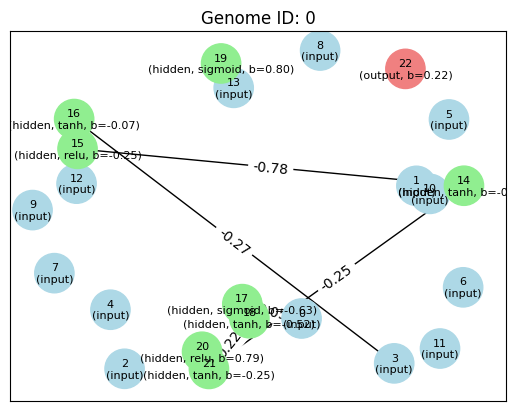

Visualizando el genoma de mejor rendimiento...


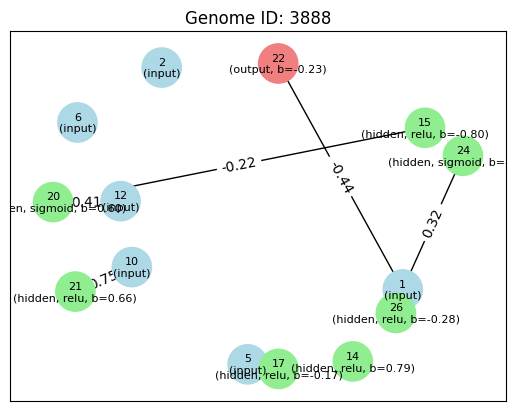

In [ ]:
import matplotlib.pyplot as plt
import pickle
import networkx as nx # Asegúrate de tener NetworkX instalado

# (Suponiendo que ya has cargado initial_genome y best_genome)

innovation_manager = InnovationManager()
initial_genome = FeedforwardGenome(genome_id = 0, num_inputs = 14, num_outputs = 1, innovation_manager = innovation_manager, initial_hidden_nodes = 8)

print("Visualizando el genoma inicial...")
initial_genome.visualize_network()


trial = 6
gem_num = 28
path_best_genome = f"/content/drive/MyDrive/VIU/TFM/results_trial_{trial}/genome_{gem_num}.pkl"

with open(path_best_genome, 'rb') as f:
    best_genome = pickle.load(f)

print("Visualizando el genoma de mejor rendimiento...")
best_genome['genome'].visualize_network()


In [ ]:
def describe_genome_structure(genome):
    G = nx.DiGraph()

    for node_id, gene_info in genome.genes.items():
        node_type = gene_info[0]
        G.add_node(node_id, type=node_type)

    for (in_node, out_node, _), weight in genome.connections.items():
        if in_node in genome.genes and out_node in genome.genes:
            G.add_edge(in_node, out_node, weight=weight)

    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Conteo por tipo
    node_types = nx.get_node_attributes(G, 'type')
    input_count = sum(1 for t in node_types.values() if t == 'input')
    hidden_count = sum(1 for t in node_types.values() if t == 'hidden')
    output_count = sum(1 for t in node_types.values() if t == 'output')

    print(" Estructura del Genoma:")
    print(f"  • Nodos totales: {num_nodes}")
    print(f"     - Entrada: {input_count}")
    print(f"     - Ocultos: {hidden_count}")
    print(f"     - Salida:  {output_count}")
    print(f"  • Conexiones totales: {num_edges}")

    # Estadísticas de pesos
    weights = [d['weight'] for _, _, d in G.edges(data=True)]
    if weights:
        print(f"  • Peso promedio de conexiones: {sum(weights)/len(weights):.3f}")
        print(f"  • Peso máximo: {max(weights):.3f}, mínimo: {min(weights):.3f}")


In [ ]:
print("\n Genoma inicial:")
describe_genome_structure(initial_genome)

print("\n Genoma óptimo:")
describe_genome_structure(best_genome['genome'])



 Genoma inicial:
 Estructura del Genoma:
  • Nodos totales: 23
     - Entrada: 14
     - Ocultos: 8
     - Salida:  1
  • Conexiones totales: 9
  • Peso promedio de conexiones: 0.198
  • Peso máximo: 0.815, mínimo: -0.780

 Genoma óptimo:
 Estructura del Genoma:
  • Nodos totales: 14
     - Entrada: 6
     - Ocultos: 7
     - Salida:  1
  • Conexiones totales: 6
  • Peso promedio de conexiones: 0.218
  • Peso máximo: 0.748, mínimo: -0.436


In [ ]:
def compare_inputs(initial_genome, best_genome):
    # Extraer los nodos de tipo 'input' de ambos genomas
    initial_inputs = {node_id for node_id, gene_info in initial_genome.genes.items() if gene_info[0] == 'input'}
    best_inputs = {node_id for node_id, gene_info in best_genome['genome'].genes.items() if gene_info[0] == 'input'}

    # Comparación
    print("Entradas en el genoma inicial:", initial_inputs)
    print("Entradas en el genoma óptimo:", best_inputs)

    # Nodos de entrada que se mantuvieron
    kept_inputs = initial_inputs.intersection(best_inputs)
    print(f"Entradas conservadas: {kept_inputs}")

    # Nodos de entrada que fueron eliminados
    removed_inputs = initial_inputs - best_inputs
    print(f"Entradas eliminadas: {removed_inputs}")

    # Nodos de entrada adicionales (si hay) en el óptimo
    added_inputs = best_inputs - initial_inputs
    print(f"Entradas adicionales en el óptimo: {added_inputs}")


In [ ]:
print("\n Comparando entradas entre el genoma inicial y el óptimo:")
compare_inputs(initial_genome, best_genome)


 Comparando entradas entre el genoma inicial y el óptimo:
Entradas en el genoma inicial: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Entradas en el genoma óptimo: {1, 2, 5, 6, 10, 12}
Entradas conservadas: {1, 2, 5, 6, 10, 12}
Entradas eliminadas: {0, 3, 4, 7, 8, 9, 11, 13}
Entradas adicionales en el óptimo: set()


In [ ]:
df_final_clean = pd.read_csv("/content/drive/MyDrive/VIU/TFM/df_final_clean.csv")

In [ ]:
# Suponiendo que best_genome es el genoma óptimo y tienes la función para obtener los nodos de entrada
input_nodes_optimal = {node_id for node_id, gene_info in best_genome['genome'].genes.items() if gene_info[0] == 'input'}
print("Nodos de entrada en el genoma óptimo:", input_nodes_optimal)


Nodos de entrada en el genoma óptimo: {1, 2, 5, 6, 10, 12}


In [ ]:
# Obtener los nombres de las columnas del DataFrame
df_columns = df_final_clean.columns.tolist()
print("Columnas del DataFrame:", df_columns)


Columnas del DataFrame: ['name', 'nodes', 'edges', 'density', 'maximum_degree', 'minimum_degree', 'average_degree', 'assortativity', 'number_of_triangles', 'average_number_of_triangles', 'maximum_number_of_triangles', 'average_clustering_coefficient', 'fraction_of_closed_triangles', 'maximum_k-core', 'lower_bound_of_maximum_clique', 'avg_node_dis']


In [ ]:
# Convertir las posiciones de los nodos de entrada a índices de columna
input_columns_by_position = [df_final_clean.columns[pos] for pos in input_nodes_optimal]
print("Columnas seleccionadas por posición:", input_columns_by_position)

# Seleccionar las columnas del DataFrame basadas en las posiciones
df_selected_inputs = df_final_clean[input_columns_by_position]
print("Sub DataFrame con las entradas seleccionadas:\n", df_selected_inputs.head())



Columnas seleccionadas por posición: ['nodes', 'edges', 'minimum_degree', 'average_degree', 'maximum_number_of_triangles', 'fraction_of_closed_triangles']
Sub DataFrame con las entradas seleccionadas:
    nodes    edges  minimum_degree  average_degree  \
0  160.0  11100.0            57.0           139.0   
1  164.0   9400.0             6.0           114.0   
2  160.0   8500.0             4.0           105.0   
3  152.0   9100.0            27.0           120.0   
4  152.0   6700.0            32.0            88.0   

   maximum_number_of_triangles  fraction_of_closed_triangles  
0                      11000.0                      0.895455  
1                       8500.0                      0.795921  
2                       7200.0                      0.748218  
3                       9000.0                      0.834365  
4                       5300.0                      0.685521  


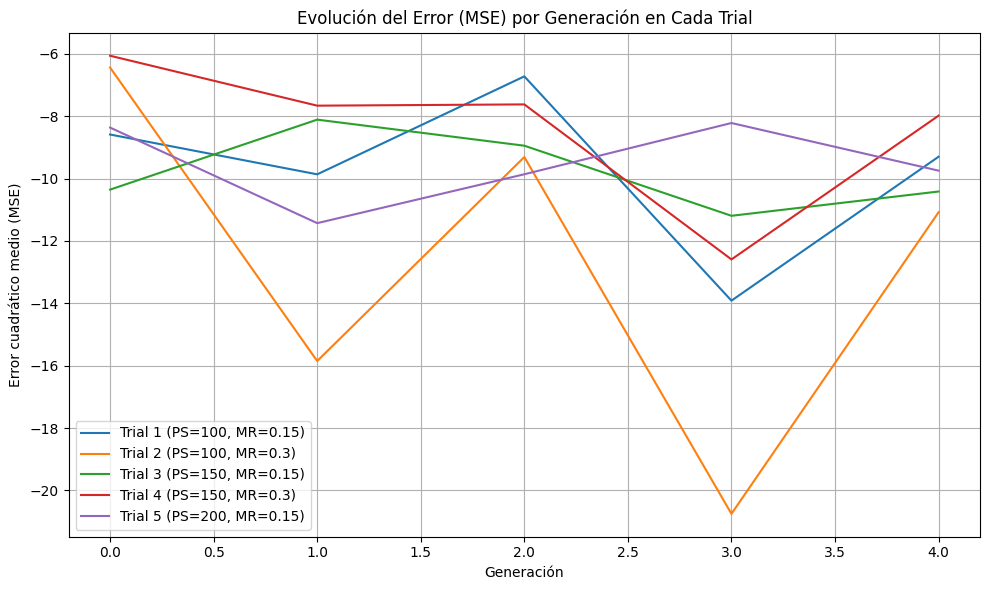

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt

def graficar_error_por_trial(ruta_carpeta):
    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap('tab10')
    archivos = sorted([
        f for f in os.listdir(ruta_carpeta)
        if f.startswith('results_trial_') and f.endswith('.pkl')
    ])

    for i, archivo in enumerate(archivos):
        ruta = os.path.join(ruta_carpeta, archivo)
        with open(ruta, 'rb') as f:
            data = pickle.load(f)
            clave = list(data.keys())[0]
            resultado = data[clave]
            errores = resultado['test_losses_per_fold']
            if errores:
                plt.plot(errores, label=f"Trial {clave} (PS={resultado['population_size']}, MR={resultado['mutation_rate']})", color=cmap(i))

    plt.title("Evolución del Error (MSE) por Generación en Cada Trial")
    plt.xlabel("Generación")
    plt.ylabel("Error cuadrático medio (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("figura1_evolucion_error_comparativa.png", dpi=300)
    plt.show()

# Ejemplo de uso:
graficar_error_por_trial("/content/drive/MyDrive/VIU/TFM")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_genoma_como_grafo(genome, nombre_archivo="mejor_genoma_grafo.png"):
    G = nx.DiGraph()

    for gene_id, gene in genome.genes.items():
        G.add_node(gene_id, tipo=gene.type)

    for (from_node, to_node), conn in genome.connections.items():
        if conn.enabled:
            G.add_edge(from_node, to_node)

    colores = {'input': 'lightblue', 'hidden': 'lightgreen', 'output': 'salmon'}
    node_colors = [colores.get(genome.genes[n].type, 'gray') for n in G.nodes]

    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=600, font_size=8, edge_color='gray')
    plt.title("Estructura del Mejor Genoma (Grafo Evolucionado)")
    plt.tight_layout()
    plt.savefig(nombre_archivo, dpi=300)
    plt.show()


In [ ]:
import pandas as pd

# Especifica la ruta al archivo metrics.csv en tu Google Drive
ruta_archivo_metrics = "/content/drive/MyDrive/VIU/TFM/results_trial_1/metrics.csv"  # Asegúrate de que esta ruta sea correcta

try:
    # Carga el archivo CSV en un DataFrame de pandas
    df_metrics = pd.read_csv(ruta_archivo_metrics)

    # Muestra las primeras 5 filas del DataFrame
    print("Primeras 5 filas del DataFrame:")
    print(df_metrics.head())
    print("\n")

    # Muestra los nombres de las columnas
    print("Nombres de las columnas:")
    print(df_metrics.columns)
    print("\n")

    # Muestra un resumen estadístico del DataFrame
    print("Resumen estadístico del DataFrame:")
    print(df_metrics.describe())

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {ruta_archivo_metrics}")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")


Primeras 5 filas del DataFrame:
   fold   genome_file   test_loss    fitness
0     1  genome_1.pkl -104.740230 -87.420642
1     2  genome_2.pkl -111.184319 -85.253411
2     3  genome_3.pkl  -85.964151 -89.745948
3     4  genome_4.pkl  -96.281849 -91.418794
4     5  genome_5.pkl -104.080853 -86.793317


Nombres de las columnas:
Index(['fold', 'genome_file', 'test_loss', 'fitness'], dtype='object')


Resumen estadístico del DataFrame:
            fold   test_loss    fitness
count  10.000000   10.000000  10.000000
mean    3.000000 -100.426838 -88.252377
std     1.490712   11.605771   3.526491
min     1.000000 -117.067875 -93.535414
25%     2.000000 -109.573297 -91.000583
50%     3.000000 -102.602269 -87.481163
75%     4.000000  -90.151142 -86.316261
max     5.000000  -83.790303 -82.164249


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
Procesando carpeta: results_trial_1
  Leyendo archivo: genome_1.pkl
    Genoma genome_1 procesado, MSE: 3.9817
  Leyendo archivo: genome_2.pkl
    Genoma genome_2 procesado, MSE: 3.4507
  Leyendo archivo: genome_3.pkl
    Genoma genome_3 procesado, MSE: 3.3992
  Leyendo archivo: genome_4.pkl
    Genoma genome_4 procesado, MSE: 4.4929
  Leyendo archivo: genome_5.pkl
    Genoma genome_5 procesado, MSE: 4.8228
Procesando carpeta: results_trial_2
  Leyendo archivo: genome_6.pkl
    Genoma genome_6 procesado, MSE: 3.8639
  Leyendo archivo: genome_7.pkl
    Genoma genome_7 procesado, MSE: 3.5987
  Leyendo archivo: genome_8.pkl
    Genoma genome_8 procesado, MSE: 6.4191
  Leyendo archivo: genome_9.pkl
    Genoma genome_9 procesado, MSE: 4.4362
  Leyendo archivo: genome_10.pkl
    Genoma genome_10 procesado, MSE: 3.9605
Procesando c

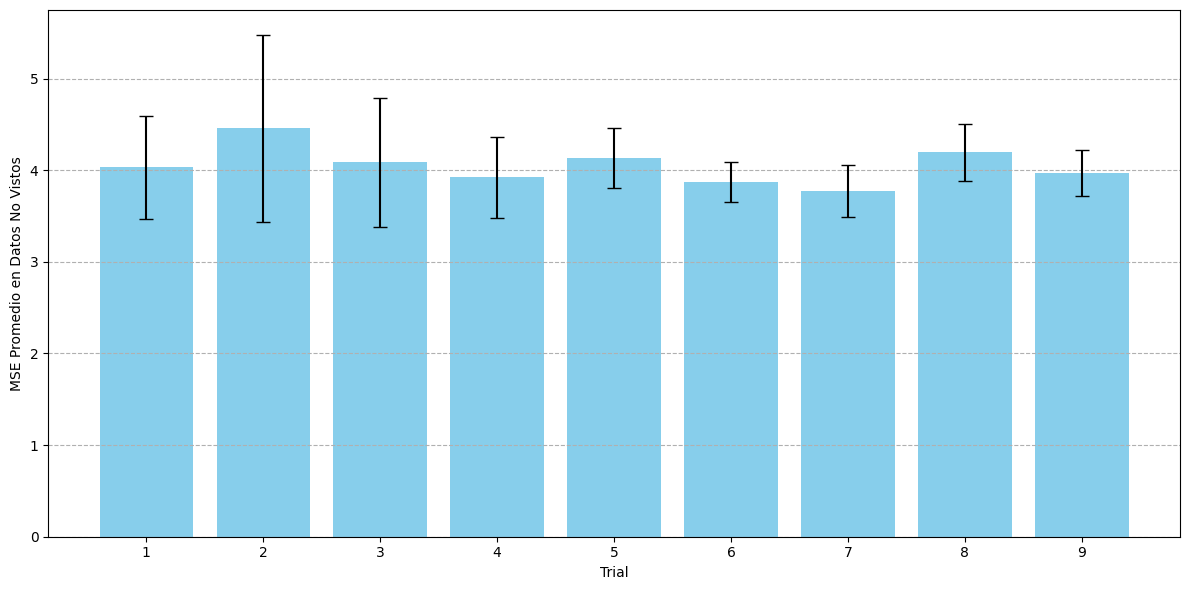


Gráfica del MSE promedio por trial guardada en:
/content/drive/MyDrive/VIU/TFM/mse_promedio_por_trial.png


In [ ]:
import pickle
import torch
import os
from sklearn.metrics import mean_squared_error
import numpy as np
from google.colab import drive
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

unseen_data_path = "/content/drive/MyDrive/VIU/TFM/unseen_data.pkl"

with open(unseen_data_path, 'rb') as f:
    unseen_data = pickle.load(f)

# 1. Montar Google Drive (si estás en Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")

# 2. Define your get_prediction_for_single_data_point function (asegúrate de que esté definida en tu código)
def get_prediction_for_single_data_point(genome, data_point):
    """Evaluates a genome on a single data point and returns prediction and true value."""
    features, true_value = data_point
    network = genome.create_pytorch_network(num_inputs=features.shape[0])
    network.eval()
    with torch.no_grad():
        prediction = network(features.unsqueeze(0)).squeeze()
    return prediction.item(), true_value.item()

# 4. Función para generar los datos de la tabla de MSE por genoma
def generar_tabla_mse_por_genoma(unseen_data, ruta_carpeta_principal='/content/drive/MyDrive/VIU/TFM'):
    """
    Carga los genomas de archivos individuales dentro de las carpetas de cada trial
    y calcula el MSE de cada genoma sobre los datos no vistos.

    Args:
        unseen_data (list): Lista de tuplas (features, true_value) para los datos no vistos.
        ruta_carpeta_principal (str, optional): Ruta a la carpeta principal que contiene las carpetas de los trials.
                                                Por defecto, '/content/drive/MyDrive/VIU/TFM'.

    Returns:
        dict: Un diccionario donde las claves son los nombres de los trials
              y los valores son listas de diccionarios, cada uno conteniendo
              el ID del genoma y el MSE.
    """
    resultados_por_trial = defaultdict(list)

    try:
        for item in os.listdir(ruta_carpeta_principal):
            ruta_carpeta_trial = os.path.join(ruta_carpeta_principal, item)
            if os.path.isdir(ruta_carpeta_trial) and item.startswith('results_trial_'):
                print(f"Procesando carpeta: {item}")
                trial_id = int(item.split('_')[-1])  # Extraer el número del trial como entero

                for filename in os.listdir(ruta_carpeta_trial):
                    if filename.startswith('genome_') and filename.endswith('.pkl'):
                        genome_id = filename[:-4]
                        filepath = os.path.join(ruta_carpeta_trial, filename)
                        print(f"  Leyendo archivo: {filename}")
                        try:
                            with open(filepath, 'rb') as f:
                                data = pickle.load(f)
                                if 'genome' in data:
                                    genome = data['genome']
                                    predictions = []
                                    true_values = []
                                    for features, true_value in unseen_data:
                                        prediction, _ = get_prediction_for_single_data_point(genome, (features, true_value))
                                        predictions.append(prediction)
                                        true_values.append(true_value.item())

                                    mse = mean_squared_error(true_values, predictions)
                                    resultados_por_trial[trial_id].append({'genome_id': genome_id, 'mse': mse})
                                    print(f"    Genoma {genome_id} procesado, MSE: {mse:.4f}")
                                else:
                                    print(f"    Advertencia: No se encontró 'genome' en {filename}")
                        except Exception as e:
                            print(f"    Error al cargar o procesar {filename}: {e}")

    except FileNotFoundError:
        print(f"Error: La carpeta '{ruta_carpeta_principal}' no fue encontrada.")
    except Exception as e:
        print(f"Ocurrió un error al procesar las carpetas: {e}")

    return resultados_por_trial

# Ejecutar la función para obtener los datos de la tabla
tabla_data_mse = generar_tabla_mse_por_genoma(unseen_data)

ps_mr_config = {}
ps = [100, 150, 200]
mr = [0.15, 0.225, 0.3]
counter = 0
for i in ps:
    for j in mr:
        counter += 1
        ps_mr_config[counter] = {'ps': i, 'mr': j}

# Imprimir la tabla en formato Markdown
print("\nTabla de Rendimiento de los Genomas en Datos No Vistos para Diferentes Configuraciones de Hiperparámetros\n")
print("| Trial | Tamaño de Población (`ps`) | Tasa de Mutación (`mr`) | MSE Genoma 1 | MSE Genoma 2 | MSE Genoma 3 | MSE Genoma 4 | MSE Genoma 5 | MSE Promedio (Trial) | Desviación Estándar (Trial) |")
print("|---|---|---|---|---|---|---|---|---|---|")

for trial_num in sorted(tabla_data_mse.keys()):
    mse_valores = []
    genome_mses = {}
    for idx, resultado in enumerate(tabla_data_mse[trial_num]):
        genome_mses[f"MSE Genoma {idx + 1}"] = f"{resultado['mse']:.4f}"
        mse_valores.append(resultado['mse'])

    ps_val = ps_mr_config.get(trial_num, {}).get('ps', 'N/A')
    mr_val = ps_mr_config.get(trial_num, {}).get('mr', 'N/A')

    promedio_mse = np.mean(mse_valores) if mse_valores else 'N/A'
    desviacion_std = np.std(mse_valores) if len(mse_valores) > 1 else 'N/A'

    row = f"| {trial_num} | {ps_val} | {mr_val} | "
    for i in range(1, 6):
        row += genome_mses.get(f"MSE Genoma {i}", 'N/A') + " | "
    row += f"{promedio_mse:.4f} | {desviacion_std:.4f} |"
    print(row)

# Generar la gráfica de barras del MSE promedio por trial
plt.figure(figsize=(12, 6))
trial_numbers = sorted(tabla_data_mse.keys())
avg_mses = [np.mean([res['mse'] for res in tabla_data_mse[trial]]) for trial in trial_numbers]
std_devs = [np.std([res['mse'] for res in tabla_data_mse[trial]]) if len(tabla_data_mse[trial]) > 1 else 0 for trial in trial_numbers]

plt.bar(trial_numbers, avg_mses, yerr=std_devs, capsize=5, color='skyblue')
plt.xlabel("Trial")
plt.ylabel("MSE Promedio en Datos No Vistos")
#plt.title("MSE Promedio por Trial en Datos No Vistos")
plt.xticks(trial_numbers)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/VIU/TFM/mse_promedio_por_trial.png") # Guardar la gráfica
plt.show()

print("\nGráfica del MSE promedio por trial guardada en:")
print("/content/drive/MyDrive/VIU/TFM/mse_promedio_por_trial.png")